<a href="https://colab.research.google.com/github/grnbatera/Data4health/blob/notebooks/An%C3%A1lise_das_Falhas_de_Diagn%C3%B3stico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Atenção: Devido a natureza dos dados, para correto funcionamento, este notebook precisa ser executado em ambiente com memória RAM maior ou igual a 25 Gb.**

#**Ciência e Visualização de Dados**
##**Projeto Final - Entrega 02**
###Alunos: 
###Gleyson Roberto do Nascimento. RA: 043801. Elétrica.
###Negli René Gallardo Alvarado. RA: 234066. Saúde.
###Rafael Vinícius da Silveira. RA: 137382. Física.
###Sérgio Sevileanu. RA: 941095. Elétrica.



##Neste notebook do Google Colaboratory será analisada a falha de diagnóstico médico ocorrida em ambiente hospitalar nos Estados de São Paulo, Bahia, Paraná, Pará e Goiás, durante os anos de 2008 a 2018 segundo o banco de dados [SIHSUS](https://bigdata-metadados.icict.fiocruz.br/dataset/sistema-de-informacoes-hospitalares-do-sus-sihsus/resource/ae85ac54-6734-43b8-a820-6129a854e1ff), representando, assim, um retrato das 5 regiões do Brasil durante este período.
##Desta forma, algumas defiinições iniciais e um disclaimer se fazem necessários:
##Será definido como **diagnóstico correto** aquele em que houve apenas um diagnóstico de CID10, sem alterações durante o período até a alta;  
##Será definido como **diagnóstico equivocado** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte do mesmo grupo, de forma que é plausível o equívoco dada a semelhança de sintomas entre os CID10;
##Será definido como **falha de diagnóstico** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte de grupos distintos, de forma que embora possam existir sintomas semelhantes entre os CID10, caberia ao profissional uma análise mais aprofundada antes do diagnóstico.
##**Disclaimer**: Considerando a natureza do banco de dados do SIHSUS, isto é, um Big Data em que inúmeros funcionários do Sistema Único de Saúde possuem acesso e inserem os dados de forma manual em realdades e condições bastante distintas, existe a séria possibildade de erro sistemático, desta forma, a acurácia deste trabalho deve ser considerada com ressalvas.

##Instalando e Importando as Bibliotecas Necessárias.

In [ ]:
!pip install dask[complete]
!pip install -U -q PyDrive

In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [ ]:
%load_ext google.colab.data_table
import numba
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import dask
from datetime import datetime
from dask import dataframe as dd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
pd.set_option('display.max_columns', None)
pd.options.display.precision = 2
pd.options.display.max_rows = 50
import seaborn as sns
import missingno as msno
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('figure', max_open_warning = 0)
import statsmodels.api as sm
from statsmodels.api import graphics
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from scipy.stats import pearsonr
from scipy.stats import spearmanr
pd.set_option('display.max_columns', None)
import itertools
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

##Fazendo Autenticação do Gooogle Drive, Baixando os Arquivos e Criando Dataframes.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
ids = ['1qX04NhLGhDxkr1XvmoHtUjs8otfP9yG2','1cko2nxWe2iuOGTIPyAwq8TrzV4-TnRXI','1Qgovfbq-SM_RS7LNse6xOz0_m4j_ClWr','1iktf4IsmItFpHOa1GdA-FrTytr3RE127','1Evl-2jtlJRK-dZs9at22ipqL35x5SToy']
estados = ['SP','BA','PR','PA','GO']
arquivo = ['sp.pkl','ba.pkl','pr.pkl','pa.pkl','go.pkl']

In [ ]:
dflist=[]
for i in range (len(ids)):
  fileDownloaded = drive.CreateFile({'id':ids[i]})
  fileDownloaded.GetContentFile(arquivo[i])
  globals()[estados[i]] = pd.read_pickle(arquivo[i])
  globals()[estados[i]] = (globals()[estados[i]]).reset_index(drop=True)
  dflist.append(eval(estados[i]))

##O dicionário de Variáveis para o arquivo é:
###**v0**: Código IBGE da Cidade;
###**v1**: Ano do Atendimento Hospitalar;
###**v14**: Gênero;
###**v48**: CID10 do Diagnóstico Principal;
###**v49**: CID10 do Diagnóstico Secundário;
###**v68**: Óbito;
###**v82**: CID10 do Diagnóstico Feito por Socorrista;
###**v104**: CID10 do Diagnóstico Primário de Causa da Morte;
###**v105**: CID10 do Diagnóstico Final de Causa da Morte;
###**v114**: Raça Declarada pelo(a) Paciente;
###**v221**: Idade Declarada pelo(a) Paciente;
###**v253**: Grupo do CID10 do Diagnóstico Principal;
###**v254**: Grupo do CID10 do Diagnóstico Secundário;
###**v255**: Grupo do CID10 do Diagnóstico Feito por Socorrista;
###**v256**: Grupo do CID10 do Diagnóstico Primário de Causa da Morte;
###**v257**: Grupo do CID10 do Diagnóstico Final de Causa da Morte;
###**v258**: Análise de Falha de Diagnóstco;
###**v259**: Condição de Óbito;
###**v260**: Total de Dias de Internação;
###**v261**: Custo Médio por Dia de Internação;
###**v262**: Custo Médio da Internação.



#Análises para o Estado de São Paulo.

##Criando a Variável de Dias de Internação. 

In [ ]:
SP['v260'] = pd.to_datetime(SP['v47'],format='%Y%m%d')-pd.to_datetime(SP['v46'],format='%Y%m%d')

In [ ]:
SP['v260'] = SP['v260'].astype('timedelta64[D]')

##Criando um Subset para Análise das Variáves de CID10. 

In [ ]:
cid = (SP[['v0','v1','v48','v49', 'v68','v82','v104','v105','v14','v114','v221','v260']]).copy()

In [ ]:
cid[['v49','v82','v104','v105']] = cid[['v49','v82','v104','v105']].replace({'0':np.nan})

In [ ]:
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260
0,350000,2008,I792,NaN,0,NaN,NaN,NaN,1,99,21,1.0
1,350000,2008,T814,W999,0,NaN,NaN,NaN,3,1,0,2.0
2,350000,2008,J938,NaN,0,NaN,NaN,NaN,1,99,23,2.0
3,350000,2008,L988,NaN,0,NaN,NaN,NaN,1,99,81,2.0
4,350000,2008,O053,NaN,0,NaN,NaN,NaN,3,1,33,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,K810,NaN,0,NaN,NaN,NaN,1,99,67,1.0
2176204,355700,2018,K810,NaN,0,NaN,NaN,NaN,3,1,58,1.0
2176205,355700,2018,O610,NaN,0,NaN,NaN,NaN,3,1,25,1.0
2176206,355700,2018,O610,NaN,0,NaN,NaN,NaN,3,1,29,3.0


##Verificando os dados de Missing das Variáveis de CID10.

###Fazendo a Matriz dos Casos de Missing para as Variáveis de CID10.

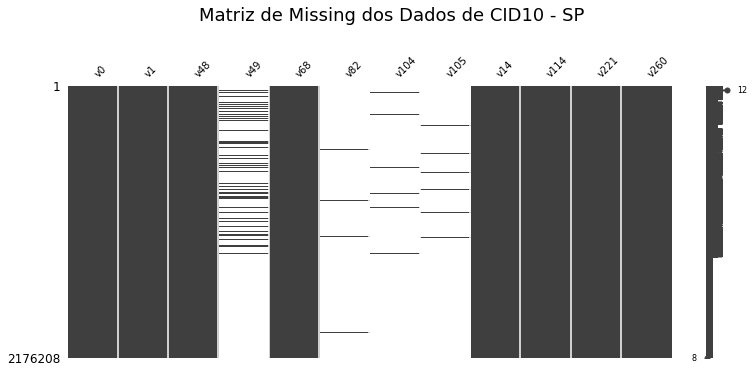

In [ ]:
msno.matrix(cid,figsize=(12, 5), fontsize=10)
plt.suptitle('Matriz de Missing dos Dados de CID10 - SP',y=1.1,fontsize=18)
plt.show()

###Fazendo o Gráfico de Barras dos Casos de Missing para as Variáveis de CID10.

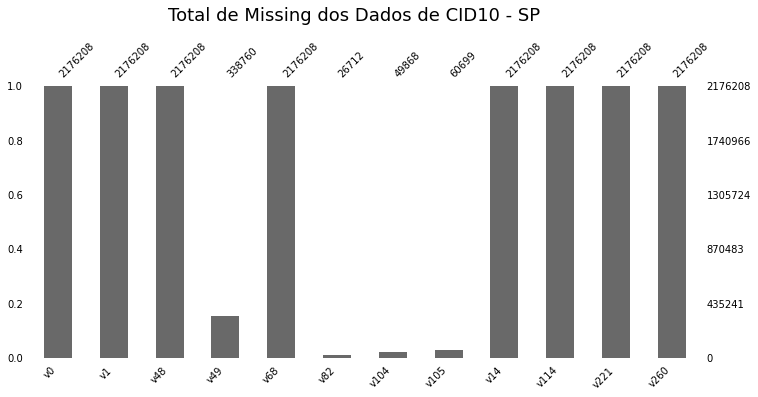

In [ ]:
msno.bar(cid,figsize=(12, 5), fontsize=10, p=False)
plt.suptitle('Total de Missing dos Dados de CID10 - SP',y=1.1,fontsize=18)
plt.show()

In [ ]:
colunas = ['v49','v82','v104','v105']

##Fazendo os Percentuais para as Variáveis de CID10.

In [ ]:
print('\033[1m'+'Percentual de Dados nas Variáveis de CID-10 - SP'+'\033[0m')
for i in range (len(colunas)):
  percentual = 100*(cid[colunas[i]].count()/cid['v48'].count())
  print('O percentual de dados em ', colunas[i], 'é de ', percentual,'%')

Percentual de Dados nas Variáveis de CID-10 - SP
O percentual de dados em  v49 é de  15.566526729062662 %
O percentual de dados em  v82 é de  1.2274561990397976 %
O percentual de dados em  v104 é de  2.29150889988457 %
O percentual de dados em  v105 é de  2.789209487328417 %


In [ ]:
for col in cid:
  print('\033[1m'+'Dados na Variável '+col+' (por Frequência)'+'\033[0m')
  print(cid[col].value_counts())
  print('\n')

Dados na Variável v0 (por Frequência)
350000    1066932
355030     227274
350950      36901
355220      28836
354990      28137
           ...   
350660         12
354430         10
355690         10
352020          9
353210          8
Name: v0, Length: 313, dtype: int64


Dados na Variável v1 (por Frequência)
2010    210764
2017    204663
2018    203507
2011    202818
2015    200105
2016    199516
2009    194281
2014    193789
2013    189555
2012    189249
2008    187961
Name: v1, dtype: int64


Dados na Variável v48 (por Frequência)
O800    102995
O809     40477
J189     39167
J180     30168
N390     29205
         ...  
D201         1
H530         1
A054         1
T388         1
L605         1
Name: v48, Length: 7324, dtype: int64


Dados na Variável v49 (por Frequência)
W199    22416
I10     16041
W019     7951
W189     7278
V299     6013
        ...  
L250        1
F071        1
V802        1
W074        1
V241        1
Name: v49, Length: 7175, dtype: int64


Dados na Variável v68

##Criando as Variáveis de Grupo do CID10.  

In [ ]:
colunas2 = ['v48','v49','v82','v104','v105']

In [ ]:
for i in range(len(colunas2)):
  cid['v{0}'.format(253+i)] = cid[colunas2[i]].astype(str).str[0:2]
cid = cid.replace({'na':np.nan})
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,350000,2008,I792,NaN,0,NaN,NaN,NaN,1,99,21,1.0,I7,NaN,NaN,NaN,NaN
1,350000,2008,T814,W999,0,NaN,NaN,NaN,3,1,0,2.0,T8,W9,NaN,NaN,NaN
2,350000,2008,J938,NaN,0,NaN,NaN,NaN,1,99,23,2.0,J9,NaN,NaN,NaN,NaN
3,350000,2008,L988,NaN,0,NaN,NaN,NaN,1,99,81,2.0,L9,NaN,NaN,NaN,NaN
4,350000,2008,O053,NaN,0,NaN,NaN,NaN,3,1,33,1.0,O0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,K810,NaN,0,NaN,NaN,NaN,1,99,67,1.0,K8,NaN,NaN,NaN,NaN
2176204,355700,2018,K810,NaN,0,NaN,NaN,NaN,3,1,58,1.0,K8,NaN,NaN,NaN,NaN
2176205,355700,2018,O610,NaN,0,NaN,NaN,NaN,3,1,25,1.0,O6,NaN,NaN,NaN,NaN
2176206,355700,2018,O610,NaN,0,NaN,NaN,NaN,3,1,29,3.0,O6,NaN,NaN,NaN,NaN


##Substituindo os valores de Missing pela string 'vazio'

In [ ]:
cidfull = cid.fillna('vazio')
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,350000,2008,I792,vazio,0,vazio,vazio,vazio,1,99,21,1.0,I7,vazio,vazio,vazio,vazio
1,350000,2008,T814,W999,0,vazio,vazio,vazio,3,1,0,2.0,T8,W9,vazio,vazio,vazio
2,350000,2008,J938,vazio,0,vazio,vazio,vazio,1,99,23,2.0,J9,vazio,vazio,vazio,vazio
3,350000,2008,L988,vazio,0,vazio,vazio,vazio,1,99,81,2.0,L9,vazio,vazio,vazio,vazio
4,350000,2008,O053,vazio,0,vazio,vazio,vazio,3,1,33,1.0,O0,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,K810,vazio,0,vazio,vazio,vazio,1,99,67,1.0,K8,vazio,vazio,vazio,vazio
2176204,355700,2018,K810,vazio,0,vazio,vazio,vazio,3,1,58,1.0,K8,vazio,vazio,vazio,vazio
2176205,355700,2018,O610,vazio,0,vazio,vazio,vazio,3,1,25,1.0,O6,vazio,vazio,vazio,vazio
2176206,355700,2018,O610,vazio,0,vazio,vazio,vazio,3,1,29,3.0,O6,vazio,vazio,vazio,vazio


##Transformando as Variáveis de CID10 em Variáveis com Categorias Numéricas.

In [ ]:
a = cidfull['v48'].unique()
b = cidfull['v49'].unique()
c = cidfull['v82'].unique()
d = cidfull['v104'].unique()
e = cidfull['v105'].unique()

In [ ]:
f=np.concatenate([a,b,c,d,e],axis=0)
f = pd.DataFrame(f.T)
f

,0
0,I792
1,T814
2,J938
3,L988
4,O053
...,...
20472,M463
20473,S357
20474,F192
20475,S823


In [ ]:
lecidsp = preprocessing.LabelEncoder()
lecidsp.fit(f)
for i in range(len(colunas2)):
  cidfull[colunas2[i]]=lecidsp.transform(cidfull[colunas2[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,350000,2008,3028,9212,0,9212,9212,9212,1,99,21,1.0,I7,vazio,vazio,vazio,vazio
1,350000,2008,7186,8131,0,9212,9212,9212,3,1,0,2.0,T8,W9,vazio,vazio,vazio
2,350000,2008,3271,9212,0,9212,9212,9212,1,99,23,2.0,J9,vazio,vazio,vazio,vazio
3,350000,2008,3932,9212,0,9212,9212,9212,1,99,81,2.0,L9,vazio,vazio,vazio,vazio
4,350000,2008,4853,9212,0,9212,9212,9212,3,1,33,1.0,O0,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,3643,9212,0,9212,9212,9212,1,99,67,1.0,K8,vazio,vazio,vazio,vazio
2176204,355700,2018,3643,9212,0,9212,9212,9212,3,1,58,1.0,K8,vazio,vazio,vazio,vazio
2176205,355700,2018,5033,9212,0,9212,9212,9212,3,1,25,1.0,O6,vazio,vazio,vazio,vazio
2176206,355700,2018,5033,9212,0,9212,9212,9212,3,1,29,3.0,O6,vazio,vazio,vazio,vazio


In [ ]:
a1 = cidfull['v253'].unique()
b1 = cidfull['v254'].unique()
c1 = cidfull['v255'].unique()
d1 = cidfull['v256'].unique()
e1 = cidfull['v257'].unique()

In [ ]:
f1=np.concatenate([a1,b1,c1,d1,e1],axis=0)
f1 = pd.DataFrame(f1.T)
f1

,0
0,I7
1,T8
2,J9
3,L9
4,O0
...,...
947,D8
948,K1
949,G7
950,W4


In [ ]:
colunas3 = ['v253','v254','v255','v256','v257']

In [ ]:
lecidsp1 = preprocessing.LabelEncoder()
lecidsp1.fit(f1)
for i in range(len(colunas2)):
  cidfull[colunas3[i]]=lecidsp1.transform(cidfull[colunas3[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,350000,2008,3028,9212,0,9212,9212,9212,1,99,21,1.0,86,248,248,248,248
1,350000,2008,7186,8131,0,9212,9212,9212,3,1,0,2.0,194,217,248,248,248
2,350000,2008,3271,9212,0,9212,9212,9212,1,99,23,2.0,97,248,248,248,248
3,350000,2008,3932,9212,0,9212,9212,9212,1,99,81,2.0,117,248,248,248,248
4,350000,2008,4853,9212,0,9212,9212,9212,3,1,33,1.0,138,248,248,248,248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,3643,9212,0,9212,9212,9212,1,99,67,1.0,106,248,248,248,248
2176204,355700,2018,3643,9212,0,9212,9212,9212,3,1,58,1.0,106,248,248,248,248
2176205,355700,2018,5033,9212,0,9212,9212,9212,3,1,25,1.0,143,248,248,248,248
2176206,355700,2018,5033,9212,0,9212,9212,9212,3,1,29,3.0,143,248,248,248,248


##Criando as Variáves de Análise de Falha de Diagnóstico e de Condição de Óbito.

In [ ]:
cidfull.loc[((cidfull['v49']==9212)&(cidfull['v82']==9212)&(cidfull['v104']==9212)&(cidfull['v105']==9212))&((cidfull['v254']==248)&(cidfull['v255']==248)&(cidfull['v256']==248)&(cidfull['v257']==248)),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']==cidfull['v49'])|(cidfull['v48']==cidfull['v82'])|(cidfull['v48']==cidfull['v104'])|(cidfull['v48']==cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])|(cidfull['v48']!=cidfull['v82'])|(cidfull['v48']!=cidfull['v104'])|(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Equivocado'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])&(cidfull['v48']!=cidfull['v82'])&(cidfull['v48']!=cidfull['v104'])&(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']!=cidfull['v254'])&(cidfull['v253']!=cidfull['v255'])&(cidfull['v253']!=cidfull['v256'])&(cidfull['v253']!=cidfull['v257']))&((cidfull['v254']!=248)|(cidfull['v255']!=248)|(cidfull['v256']!=248)|(cidfull['v257']!=248)),'v258']='Falha de Diagnóstico'
cidfull.loc[cidfull['v68']==0,'v259']='Não houve óbito'
cidfull.loc[(cidfull['v257']==248)&(cidfull['v68']==1),'v259']='Houve óbito sem CID10 declarada'
cidfull.loc[(cidfull['v257']!=248)&(cidfull['v68']==1),'v259']='Houve óbito com CID10 declarada'
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259
0,350000,2008,3028,9212,0,9212,9212,9212,1,99,21,1.0,86,248,248,248,248,Diagnóstico Correto,Não houve óbito
1,350000,2008,7186,8131,0,9212,9212,9212,3,1,0,2.0,194,217,248,248,248,Falha de Diagnóstico,Não houve óbito
2,350000,2008,3271,9212,0,9212,9212,9212,1,99,23,2.0,97,248,248,248,248,Diagnóstico Correto,Não houve óbito
3,350000,2008,3932,9212,0,9212,9212,9212,1,99,81,2.0,117,248,248,248,248,Diagnóstico Correto,Não houve óbito
4,350000,2008,4853,9212,0,9212,9212,9212,3,1,33,1.0,138,248,248,248,248,Diagnóstico Correto,Não houve óbito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,3643,9212,0,9212,9212,9212,1,99,67,1.0,106,248,248,248,248,Diagnóstico Correto,Não houve óbito
2176204,355700,2018,3643,9212,0,9212,9212,9212,3,1,58,1.0,106,248,248,248,248,Diagnóstico Correto,Não houve óbito
2176205,355700,2018,5033,9212,0,9212,9212,9212,3,1,25,1.0,143,248,248,248,248,Diagnóstico Correto,Não houve óbito
2176206,355700,2018,5033,9212,0,9212,9212,9212,3,1,29,3.0,143,248,248,248,248,Diagnóstico Correto,Não houve óbito


##Fazendo o Download de Arquivo de Custos de Atendimento Médico, Criando um Dataframe e Fazendo o Merge de Arquivos para Obter os Custos Relativos às Internações.  

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1corB_xGrJ3NDFpIXuKDl6Dri_tlPLzI0'})
fileDownloaded.GetContentFile('anual.xlsx')
anual = pd.read_excel('anual.xlsx',sheet_name='anual')

In [ ]:
anual['cep'] = [i[0] for i in anual.v241.str.split(' ').values]

In [ ]:
anual['cep']=anual['cep'].astype('int64')
anual.columns = ['v1',	'v241',	'v242',	'v243',	'v244',	'v245',	'v246',	'v247',	'v248',	'v249',	'v250',	'v261','v251',	'v252','v0']

In [ ]:
full = pd.merge(cidfull,anual[['v0','v1','v261']], on=['v0','v1'],how='left')

In [ ]:
full = full.fillna(0)
full['v262'] = full['v260']*full['v261']
full['v14'] = full['v14'].replace({1:'M',2:'F',3:'F'})
full['v114'] = full['v114'].replace({1:'Branca',2:'Preta',3:'Parda', 4:'Amarela', 5:'Vermelha', 99:'Não Declarada'})
full

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259,v261,v262
0,350000,2008,3028,9212,0,9212,9212,9212,M,Não Declarada,21,1.0,86,248,248,248,248,Diagnóstico Correto,Não houve óbito,0.00,0.00
1,350000,2008,7186,8131,0,9212,9212,9212,F,Branca,0,2.0,194,217,248,248,248,Falha de Diagnóstico,Não houve óbito,0.00,0.00
2,350000,2008,3271,9212,0,9212,9212,9212,M,Não Declarada,23,2.0,97,248,248,248,248,Diagnóstico Correto,Não houve óbito,0.00,0.00
3,350000,2008,3932,9212,0,9212,9212,9212,M,Não Declarada,81,2.0,117,248,248,248,248,Diagnóstico Correto,Não houve óbito,0.00,0.00
4,350000,2008,4853,9212,0,9212,9212,9212,F,Branca,33,1.0,138,248,248,248,248,Diagnóstico Correto,Não houve óbito,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176203,355700,2018,3643,9212,0,9212,9212,9212,M,Não Declarada,67,1.0,106,248,248,248,248,Diagnóstico Correto,Não houve óbito,152.82,152.82
2176204,355700,2018,3643,9212,0,9212,9212,9212,F,Branca,58,1.0,106,248,248,248,248,Diagnóstico Correto,Não houve óbito,152.82,152.82
2176205,355700,2018,5033,9212,0,9212,9212,9212,F,Branca,25,1.0,143,248,248,248,248,Diagnóstico Correto,Não houve óbito,152.82,152.82
2176206,355700,2018,5033,9212,0,9212,9212,9212,F,Branca,29,3.0,143,248,248,248,248,Diagnóstico Correto,Não houve óbito,152.82,458.46


##Imprimindo algumas Métricas Encontradas.

In [ ]:
p1 = 100*full['v258'].value_counts()/len(full)
p2 = 100*full['v259'].value_counts()/len(full)
p3 = 100*full['v258'].groupby(full['v259']).value_counts()/len(full)
p4 = 100*full['v258'].groupby(full['v259']).value_counts(normalize = True)
p5 = 100*full['v258'].groupby(full['v14']).value_counts()/len(full)
p6 = 100*full['v258'].groupby(full['v14']).value_counts(normalize = True)
p7 = 100*full['v49'].groupby(full['v258']).value_counts()/len(full)
p8 = 100*full['v49'].groupby(full['v258']).value_counts(normalize = True)
p9 = 100*full['v105'].groupby(full['v258']).value_counts()/len(full)
p10 = 100*full['v105'].groupby(full['v258']).value_counts(normalize = True)
p11 = full.groupby(['v258','v259']).agg({'v262': ['mean', 'median', 'min', 'max','std']})
p12 = full.groupby(['v258','v259']).agg({'v260': ['mean', 'median', 'min', 'max','std']})
p13 = 100*full['v114'].groupby(full['v258']).value_counts()/len(full)
p14 = 100*full['v114'].groupby(full['v258']).value_counts(normalize = True)
dc1 = list(lecidsp.inverse_transform([9212]))
de1 = list(lecidsp.inverse_transform([9212,2123,2340,2748]))
df1 = list(lecidsp.inverse_transform([9198,9201,9202,9203,9204]))
dc2 = list(lecidsp.inverse_transform([9212]))
de2 = list(lecidsp.inverse_transform([9212,154,3285,3148]))
df2 = list(lecidsp.inverse_transform([9116,9119,9123,9185,9208]))
print('\033[1m'+'Análise dos Pecentuais de Diagnóstico'+'\033[0m')
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico')
print(p1)
print('\n')
print('Percentual Total de Diagnósticos por Condição de Óbito')
print(p2)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito')
print(p3)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Condição de Óbito')
print(p4)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Gênero')
print(p5)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pelo Gênero')
print(p6)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p7)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p8)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Houve Óbito')
print(p9)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Houve Óbito')
print(p10)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Custos de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p11)
print('\n')
print('Tempo de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p12)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Raça')
print(p13)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Raça')
print(p14)
print('\n')

Análise dos Pecentuais de Diagnóstico


Percentual Total de Cada Tipo de Diagnóstico
Diagnóstico Correto       81.26
Falha de Diagnóstico      14.49
Diagnóstico Equivocado     4.26
Name: v258, dtype: float64


Percentual Total de Diagnósticos por Condição de Óbito
Não houve óbito                    95.40
Houve óbito com CID10 declarada     2.79
Houve óbito sem CID10 declarada     1.82
Name: v259, dtype: float64


Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito
v259                             v258                  
Houve óbito com CID10 declarada  Diagnóstico Equivocado     1.41
                                 Falha de Diagnóstico       1.38
Houve óbito sem CID10 declarada  Diagnóstico Correto        1.82
Não houve óbito                  Diagnóstico Correto       79.44
                                 Falha de Diagnóstico      13.10
                                 Diagnóstico Equivocado     2.85
Name: v258, dtype: float64


Percentual Relativo de Cada Tipo de Diagnóst

#Análises para o Estado da Bahia.

##Criando a Variável de Dias de Internação. 

In [ ]:
BA['v260'] = pd.to_datetime(BA['v47'],format='%Y%m%d')-pd.to_datetime(BA['v46'],format='%Y%m%d')

In [ ]:
BA['v260'] = BA['v260'].astype('timedelta64[D]')

##Criando um Subset para Análise das Variáves de CID10. 

In [ ]:
cid = (BA[['v0','v1','v48','v49', 'v68','v82','v104','v105','v14','v114','v221','v260']]).copy()

In [ ]:
cid[['v49','v82','v104','v105']] = cid[['v49','v82','v104','v105']].replace({'0':np.nan})

In [ ]:
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260
0,290000,2008,A049,NaN,0,NaN,NaN,NaN,1,3,21,2.0
1,290000,2008,A049,NaN,0,NaN,NaN,NaN,1,3,32,3.0
2,290000,2008,J158,NaN,0,NaN,NaN,NaN,3,3,30,2.0
3,290000,2008,N390,NaN,0,NaN,NaN,NaN,1,3,78,3.0
4,290000,2008,J459,NaN,0,NaN,NaN,NaN,3,3,55,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,3,15,1.0
722627,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,3,37,1.0
722628,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,99,27,2.0
722629,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,3,19,2.0


##Verificando os dados de Missing das Variáveis de CID10.

###Fazendo a Matriz dos Casos de Missing para as Variáveis de CID10.

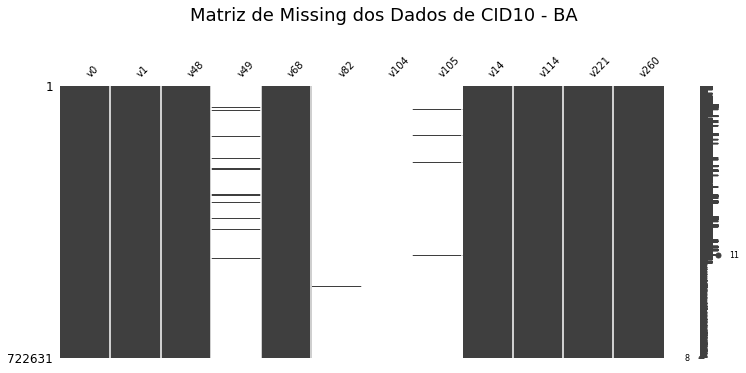

In [ ]:
msno.matrix(cid,figsize=(12, 5), fontsize=10)
plt.suptitle('Matriz de Missing dos Dados de CID10 - BA',y=1.1,fontsize=18)
plt.show()

###Fazendo o Gráfico de Barras dos Casos de Missing para as Variáveis de CID10.

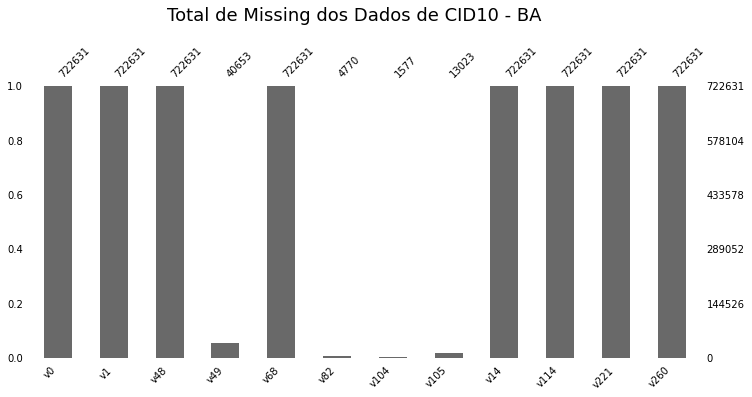

In [ ]:
msno.bar(cid,figsize=(12, 5), fontsize=10, p=False)
plt.suptitle('Total de Missing dos Dados de CID10 - BA',y=1.1,fontsize=18)
plt.show()

In [ ]:
colunas = ['v49','v82','v104','v105']

##Fazendo os Percentuais para as Variáveis de CID10.

In [ ]:
print('\033[1m'+'Percentual de Dados nas Variáveis de CID-10 - BA'+'\033[0m')
for i in range (len(colunas)):
  percentual = 100*(cid[colunas[i]].count()/cid['v48'].count())
  print('O percentual de dados em ', colunas[i], 'é de ', percentual,'%')

Percentual de Dados nas Variáveis de CID-10 - BA
O percentual de dados em  v49 é de  5.625692780962898 %
O percentual de dados em  v82 é de  0.6600879286938978 %
O percentual de dados em  v104 é de  0.21823032778831797 %
O percentual de dados em  v105 é de  1.802164590226547 %


In [ ]:
for col in cid:
  print('\033[1m'+'Dados na Variável '+col+' (por Frequência)'+'\033[0m')
  print(cid[col].value_counts())
  print('\n')

Dados na Variável v0 (por Frequência)
290000    436711
292740     79956
291080     24176
293330     23126
291840     11198
           ...  
290020        24
292590        14
293020        10
293000         9
291050         3
Name: v0, Length: 112, dtype: int64


Dados na Variável v1 (por Frequência)
2009    73176
2010    71454
2011    69560
2014    66995
2008    65167
2015    65105
2013    64173
2018    63835
2017    63421
2012    60655
2016    59090
Name: v1, dtype: int64


Dados na Variável v48 (por Frequência)
O800    66021
A09     22621
O809    16072
J459    15924
A049    11502
        ...  
Z420        1
P809        1
I774        1
G603        1
G08         1
Name: v48, Length: 5320, dtype: int64


Dados na Variável v49 (por Frequência)
W199    5106
W999    3966
W178    2053
Y099    1639
Y86     1459
        ... 
M238       1
X195       1
W683       1
W291       1
E882       1
Name: v49, Length: 1995, dtype: int64


Dados na Variável v68 (por Frequência)
0    700558
1     22073
Na

##Criando as Variáveis de Grupo do CID10.  

In [ ]:
colunas2 = ['v48','v49','v82','v104','v105']

In [ ]:
for i in range(len(colunas2)):
  cid['v{0}'.format(253+i)] = cid[colunas2[i]].astype(str).str[0:2]
cid = cid.replace({'na':np.nan})
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,290000,2008,A049,NaN,0,NaN,NaN,NaN,1,3,21,2.0,A0,NaN,NaN,NaN,NaN
1,290000,2008,A049,NaN,0,NaN,NaN,NaN,1,3,32,3.0,A0,NaN,NaN,NaN,NaN
2,290000,2008,J158,NaN,0,NaN,NaN,NaN,3,3,30,2.0,J1,NaN,NaN,NaN,NaN
3,290000,2008,N390,NaN,0,NaN,NaN,NaN,1,3,78,3.0,N3,NaN,NaN,NaN,NaN
4,290000,2008,J459,NaN,0,NaN,NaN,NaN,3,3,55,2.0,J4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,3,15,1.0,O8,NaN,NaN,NaN,NaN
722627,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,3,37,1.0,O8,NaN,NaN,NaN,NaN
722628,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,99,27,2.0,O8,NaN,NaN,NaN,NaN
722629,293360,2018,O800,NaN,0,NaN,NaN,NaN,3,3,19,2.0,O8,NaN,NaN,NaN,NaN


##Substituindo os valores de Missing pela string 'vazio'

In [ ]:
cidfull = cid.fillna('vazio')
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,290000,2008,A049,vazio,0,vazio,vazio,vazio,1,3,21,2.0,A0,vazio,vazio,vazio,vazio
1,290000,2008,A049,vazio,0,vazio,vazio,vazio,1,3,32,3.0,A0,vazio,vazio,vazio,vazio
2,290000,2008,J158,vazio,0,vazio,vazio,vazio,3,3,30,2.0,J1,vazio,vazio,vazio,vazio
3,290000,2008,N390,vazio,0,vazio,vazio,vazio,1,3,78,3.0,N3,vazio,vazio,vazio,vazio
4,290000,2008,J459,vazio,0,vazio,vazio,vazio,3,3,55,2.0,J4,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,O800,vazio,0,vazio,vazio,vazio,3,3,15,1.0,O8,vazio,vazio,vazio,vazio
722627,293360,2018,O800,vazio,0,vazio,vazio,vazio,3,3,37,1.0,O8,vazio,vazio,vazio,vazio
722628,293360,2018,O800,vazio,0,vazio,vazio,vazio,3,99,27,2.0,O8,vazio,vazio,vazio,vazio
722629,293360,2018,O800,vazio,0,vazio,vazio,vazio,3,3,19,2.0,O8,vazio,vazio,vazio,vazio


##Transformando as Variáveis de CID10 em Variáveis com Categorias Numéricas.

In [ ]:
a = cidfull['v48'].unique()
b = cidfull['v49'].unique()
c = cidfull['v82'].unique()
d = cidfull['v104'].unique()
e = cidfull['v105'].unique()

In [ ]:
f=np.concatenate([a,b,c,d,e],axis=0)
f = pd.DataFrame(f.T)
f

,0
0,A049
1,J158
2,N390
3,J459
4,O800
...,...
9083,C006
9084,K801
9085,W100
9086,D571


In [ ]:
lecidba = preprocessing.LabelEncoder()
lecidba.fit(f)
for i in range(len(colunas2)):
  cidfull[colunas2[i]]=lecidba.transform(cidfull[colunas2[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,290000,2008,26,6314,0,6314,6314,6314,1,3,21,2.0,A0,vazio,vazio,vazio,vazio
1,290000,2008,26,6314,0,6314,6314,6314,1,3,32,3.0,A0,vazio,vazio,vazio,vazio
2,290000,2008,2264,6314,0,6314,6314,6314,3,3,30,2.0,J1,vazio,vazio,vazio,vazio
3,290000,2008,3406,6314,0,6314,6314,6314,1,3,78,3.0,N3,vazio,vazio,vazio,vazio
4,290000,2008,2334,6314,0,6314,6314,6314,3,3,55,2.0,J4,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,3841,6314,0,6314,6314,6314,3,3,15,1.0,O8,vazio,vazio,vazio,vazio
722627,293360,2018,3841,6314,0,6314,6314,6314,3,3,37,1.0,O8,vazio,vazio,vazio,vazio
722628,293360,2018,3841,6314,0,6314,6314,6314,3,99,27,2.0,O8,vazio,vazio,vazio,vazio
722629,293360,2018,3841,6314,0,6314,6314,6314,3,3,19,2.0,O8,vazio,vazio,vazio,vazio


In [ ]:
a1 = cidfull['v253'].unique()
b1 = cidfull['v254'].unique()
c1 = cidfull['v255'].unique()
d1 = cidfull['v256'].unique()
e1 = cidfull['v257'].unique()

In [ ]:
f1=np.concatenate([a1,b1,c1,d1,e1],axis=0)
f1 = pd.DataFrame(f1.T)
f1

,0
0,A0
1,J1
2,N3
3,J4
4,O8
...,...
766,Y0
767,S4
768,F2
769,X4


In [ ]:
colunas3 = ['v253','v254','v255','v256','v257']

In [ ]:
lecidba1 = preprocessing.LabelEncoder()
lecidba1.fit(f1)
for i in range(len(colunas2)):
  cidfull[colunas3[i]]=lecidba1.transform(cidfull[colunas3[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,290000,2008,26,6314,0,6314,6314,6314,1,3,21,2.0,0,246,246,246,246
1,290000,2008,26,6314,0,6314,6314,6314,1,3,32,3.0,0,246,246,246,246
2,290000,2008,2264,6314,0,6314,6314,6314,3,3,30,2.0,90,246,246,246,246
3,290000,2008,3406,6314,0,6314,6314,6314,1,3,78,3.0,131,246,246,246,246
4,290000,2008,2334,6314,0,6314,6314,6314,3,3,55,2.0,93,246,246,246,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,3841,6314,0,6314,6314,6314,3,3,15,1.0,145,246,246,246,246
722627,293360,2018,3841,6314,0,6314,6314,6314,3,3,37,1.0,145,246,246,246,246
722628,293360,2018,3841,6314,0,6314,6314,6314,3,99,27,2.0,145,246,246,246,246
722629,293360,2018,3841,6314,0,6314,6314,6314,3,3,19,2.0,145,246,246,246,246


##Criando as Variáves de Análise de Falha de Diagnóstico e de Condição de Óbito.

In [ ]:
cidfull.loc[((cidfull['v49']==6314)&(cidfull['v82']==6314)&(cidfull['v104']==6314)&(cidfull['v105']==6314))&((cidfull['v254']==246)&(cidfull['v255']==246)&(cidfull['v256']==246)&(cidfull['v257']==246)),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']==cidfull['v49'])|(cidfull['v48']==cidfull['v82'])|(cidfull['v48']==cidfull['v104'])|(cidfull['v48']==cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])|(cidfull['v48']!=cidfull['v82'])|(cidfull['v48']!=cidfull['v104'])|(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Equivocado'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])&(cidfull['v48']!=cidfull['v82'])&(cidfull['v48']!=cidfull['v104'])&(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']!=cidfull['v254'])&(cidfull['v253']!=cidfull['v255'])&(cidfull['v253']!=cidfull['v256'])&(cidfull['v253']!=cidfull['v257']))&((cidfull['v254']!=246)|(cidfull['v255']!=246)|(cidfull['v256']!=246)|(cidfull['v257']!=246)),'v258']='Falha de Diagnóstico'
cidfull.loc[cidfull['v68']==0,'v259']='Não houve óbito'
cidfull.loc[(cidfull['v257']==246)&(cidfull['v68']==1),'v259']='Houve óbito sem CID10 declarada'
cidfull.loc[(cidfull['v257']!=246)&(cidfull['v68']==1),'v259']='Houve óbito com CID10 declarada'
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259
0,290000,2008,26,6314,0,6314,6314,6314,1,3,21,2.0,0,246,246,246,246,Diagnóstico Correto,Não houve óbito
1,290000,2008,26,6314,0,6314,6314,6314,1,3,32,3.0,0,246,246,246,246,Diagnóstico Correto,Não houve óbito
2,290000,2008,2264,6314,0,6314,6314,6314,3,3,30,2.0,90,246,246,246,246,Diagnóstico Correto,Não houve óbito
3,290000,2008,3406,6314,0,6314,6314,6314,1,3,78,3.0,131,246,246,246,246,Diagnóstico Correto,Não houve óbito
4,290000,2008,2334,6314,0,6314,6314,6314,3,3,55,2.0,93,246,246,246,246,Diagnóstico Correto,Não houve óbito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,3841,6314,0,6314,6314,6314,3,3,15,1.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito
722627,293360,2018,3841,6314,0,6314,6314,6314,3,3,37,1.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito
722628,293360,2018,3841,6314,0,6314,6314,6314,3,99,27,2.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito
722629,293360,2018,3841,6314,0,6314,6314,6314,3,3,19,2.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito


##Fazendo o Download de Arquivo de Custos de Atendimento Médico, Criando um Dataframe e Fazendo o Merge de Arquivos para Obter os Custos Relativos às Internações.  

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1corB_xGrJ3NDFpIXuKDl6Dri_tlPLzI0'})
fileDownloaded.GetContentFile('anual.xlsx')
anual = pd.read_excel('anual.xlsx',sheet_name='anual')

In [ ]:
anual['cep'] = [i[0] for i in anual.v241.str.split(' ').values]

In [ ]:
anual['cep']=anual['cep'].astype('int64')
anual.columns = ['v1',	'v241',	'v242',	'v243',	'v244',	'v245',	'v246',	'v247',	'v248',	'v249',	'v250',	'v261','v251',	'v252','v0']

In [ ]:
full = pd.merge(cidfull,anual[['v0','v1','v261']], on=['v0','v1'],how='left')

In [ ]:
full = full.fillna(0)
full['v262'] = full['v260']*full['v261']
full['v14'] = full['v14'].replace({1:'M',2:'F',3:'F'})
full['v114'] = full['v114'].replace({1:'Branca',2:'Preta',3:'Parda', 4:'Amarela', 5:'Vermelha', 99:'Não Declarada'})
full

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259,v261,v262
0,290000,2008,26,6314,0,6314,6314,6314,M,Parda,21,2.0,0,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
1,290000,2008,26,6314,0,6314,6314,6314,M,Parda,32,3.0,0,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
2,290000,2008,2264,6314,0,6314,6314,6314,F,Parda,30,2.0,90,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
3,290000,2008,3406,6314,0,6314,6314,6314,M,Parda,78,3.0,131,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
4,290000,2008,2334,6314,0,6314,6314,6314,F,Parda,55,2.0,93,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722626,293360,2018,3841,6314,0,6314,6314,6314,F,Parda,15,1.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito,139.41,139.41
722627,293360,2018,3841,6314,0,6314,6314,6314,F,Parda,37,1.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito,139.41,139.41
722628,293360,2018,3841,6314,0,6314,6314,6314,F,Não Declarada,27,2.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito,139.41,278.82
722629,293360,2018,3841,6314,0,6314,6314,6314,F,Parda,19,2.0,145,246,246,246,246,Diagnóstico Correto,Não houve óbito,139.41,278.82


##Imprimindo algumas Métricas Encontradas.

In [ ]:
p1 = 100*full['v258'].value_counts()/len(full)
p2 = 100*full['v259'].value_counts()/len(full)
p3 = 100*full['v258'].groupby(full['v259']).value_counts()/len(full)
p4 = 100*full['v258'].groupby(full['v259']).value_counts(normalize = True)
p5 = 100*full['v258'].groupby(full['v14']).value_counts()/len(full)
p6 = 100*full['v258'].groupby(full['v14']).value_counts(normalize = True)
p7 = 100*full['v49'].groupby(full['v258']).value_counts()/len(full)
p8 = 100*full['v49'].groupby(full['v258']).value_counts(normalize = True)
p9 = 100*full['v105'].groupby(full['v258']).value_counts()/len(full)
p10 = 100*full['v105'].groupby(full['v258']).value_counts(normalize = True)
p11 = full.groupby(['v258','v259']).agg({'v262': ['mean', 'median', 'min', 'max','std']})
p12 = full.groupby(['v258','v259']).agg({'v260': ['mean', 'median', 'min', 'max','std']})
p13 = 100*full['v114'].groupby(full['v258']).value_counts()/len(full)
p14 = 100*full['v114'].groupby(full['v258']).value_counts(normalize = True)
dc1 = list(lecidba.inverse_transform([6314]))
de1 = list(lecidba.inverse_transform([6314,5993,5374,5594]))
df1 = list(lecidba.inverse_transform([6299,6300,6304,6305,6312]))
dc2 = list(lecidba.inverse_transform([6314]))
de2 = list(lecidba.inverse_transform([6314,2115,134,2379]))
df2 = list(lecidba.inverse_transform([6293,6294,6295,6296,6310]))
print('\033[1m'+'Análise dos Pecentuais de Diagnóstico'+'\033[0m')
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico')
print(p1)
print('\n')
print('Percentual Total de Diagnósticos por Condição de Óbito')
print(p2)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito')
print(p3)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Condição de Óbito')
print(p4)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Gênero')
print(p5)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pelo Gênero')
print(p6)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p7)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p8)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Houve Óbito')
print(p9)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Houve Óbito')
print(p10)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Custos de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p11)
print('\n')
print('Tempo de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p12)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Raça')
print(p13)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Raça')
print(p14)
print('\n')

Análise dos Pecentuais de Diagnóstico


Percentual Total de Cada Tipo de Diagnóstico
Diagnóstico Correto       92.06
Falha de Diagnóstico       5.94
Diagnóstico Equivocado     2.00
Name: v258, dtype: float64


Percentual Total de Diagnósticos por Condição de Óbito
Não houve óbito                    96.95
Houve óbito com CID10 declarada     1.80
Houve óbito sem CID10 declarada     1.25
Name: v259, dtype: float64


Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito
v259                             v258                  
Houve óbito com CID10 declarada  Diagnóstico Equivocado     1.12
                                 Falha de Diagnóstico       0.68
Houve óbito sem CID10 declarada  Diagnóstico Correto        1.25
Não houve óbito                  Diagnóstico Correto       90.81
                                 Falha de Diagnóstico       5.26
                                 Diagnóstico Equivocado     0.88
Name: v258, dtype: float64


Percentual Relativo de Cada Tipo de Diagnóst

#Análises para o Estado do Paraná.

##Criando a Variável de Dias de Internação. 

In [ ]:
PR['v260'] = pd.to_datetime(PR['v47'],format='%Y%m%d')-pd.to_datetime(PR['v46'],format='%Y%m%d')

In [ ]:
PR['v260'] = PR['v260'].astype('timedelta64[D]')

##Criando um Subset para Análise das Variáves de CID10. 

In [ ]:
cid = (PR[['v0','v1','v48','v49', 'v68','v82','v104','v105','v14','v114','v221','v260']]).copy()

In [ ]:
cid[['v49','v82','v104','v105']] = cid[['v49','v82','v104','v105']].replace({'0':np.nan})

In [ ]:
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260
0,410000,2008,N111,NaN,0,NaN,NaN,NaN,3,99,65,3.0
1,410000,2008,J189,NaN,0,NaN,NaN,NaN,3,1,0,3.0
2,410000,2008,J189,NaN,0,NaN,NaN,NaN,1,1,0,4.0
3,410000,2008,D539,NaN,0,NaN,NaN,NaN,1,1,8,2.0
4,410000,2008,K359,NaN,0,NaN,NaN,NaN,1,1,15,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,F200,NaN,0,NaN,NaN,NaN,1,99,39,94.0
713171,412810,2018,F206,NaN,0,NaN,NaN,NaN,1,99,46,37.0
713172,412810,2018,F102,NaN,0,NaN,NaN,NaN,1,99,54,38.0
713173,412810,2018,F192,NaN,0,NaN,NaN,NaN,1,99,37,34.0


##Verificando os dados de Missing das Variáveis de CID10.

###Fazendo a Matriz dos Casos de Missing para as Variáveis de CID10.

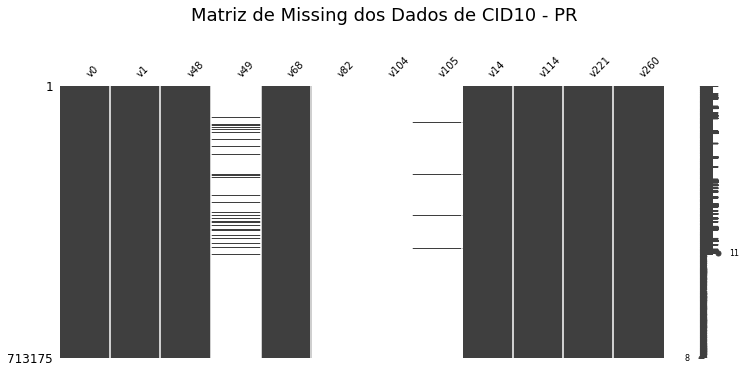

In [ ]:
msno.matrix(cid,figsize=(12, 5), fontsize=10)
plt.suptitle('Matriz de Missing dos Dados de CID10 - PR',y=1.1,fontsize=18)
plt.show()

###Fazendo o Gráfico de Barras dos Casos de Missing para as Variáveis de CID10.

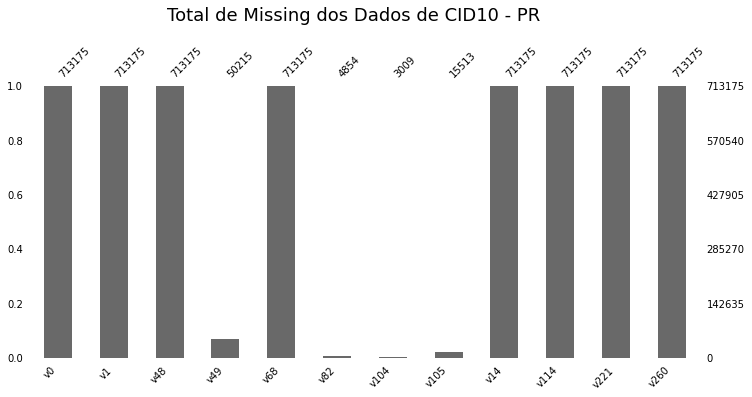

In [ ]:
msno.bar(cid,figsize=(12, 5), fontsize=10, p=False)
plt.suptitle('Total de Missing dos Dados de CID10 - PR',y=1.1,fontsize=18)
plt.show()

In [ ]:
colunas = ['v49','v82','v104','v105']

##Fazendo os Percentuais para as Variáveis de CID10.

In [ ]:
print('\033[1m'+'Percentual de Dados nas Variáveis de CID-10 - PR'+'\033[0m')
for i in range (len(colunas)):
  percentual = 100*(cid[colunas[i]].count()/cid['v48'].count())
  print('O percentual de dados em ', colunas[i], 'é de ', percentual,'%')

Percentual de Dados nas Variáveis de CID-10 - PR
O percentual de dados em  v49 é de  7.041048830932099 %
O percentual de dados em  v82 é de  0.6806183615522137 %
O percentual de dados em  v104 é de  0.42191607950362814 %
O percentual de dados em  v105 é de  2.1752024397938796 %


In [ ]:
for col in cid:
  print('\033[1m'+'Dados na Variável '+col+' (por Frequência)'+'\033[0m')
  print(cid[col].value_counts())
  print('\n')

Dados na Variável v0 (por Frequência)
410000    399303
410690    138020
411370     45458
411520     32104
412810     12885
410140     10752
411850     10473
410830     10060
410430      9677
410840      8082
412550      6004
410550      5784
410180      5170
411760      3067
410720      2798
410860      2765
411420      1673
412720       974
411540       934
410590       785
410660       766
410650       599
411080       555
412800       524
410050       489
412380       482
410540       448
410260       406
410880       357
411910       319
411060       296
412535       250
410045       213
411220       189
411440       182
411890       124
412760       105
410832       103
Name: v0, dtype: int64


Dados na Variável v1 (por Frequência)
2017    71898
2018    70796
2010    65603
2009    64945
2016    64823
2011    64820
2015    63630
2012    62302
2008    62251
2014    61371
2013    60736
Name: v1, dtype: int64


Dados na Variável v48 (por Frequência)
O800    28582
J189    17947
I200   

##Criando as Variáveis de Grupo do CID10.  

In [ ]:
colunas2 = ['v48','v49','v82','v104','v105']

In [ ]:
for i in range(len(colunas2)):
  cid['v{0}'.format(253+i)] = cid[colunas2[i]].astype(str).str[0:2]
cid = cid.replace({'na':np.nan})
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,410000,2008,N111,NaN,0,NaN,NaN,NaN,3,99,65,3.0,N1,NaN,NaN,NaN,NaN
1,410000,2008,J189,NaN,0,NaN,NaN,NaN,3,1,0,3.0,J1,NaN,NaN,NaN,NaN
2,410000,2008,J189,NaN,0,NaN,NaN,NaN,1,1,0,4.0,J1,NaN,NaN,NaN,NaN
3,410000,2008,D539,NaN,0,NaN,NaN,NaN,1,1,8,2.0,D5,NaN,NaN,NaN,NaN
4,410000,2008,K359,NaN,0,NaN,NaN,NaN,1,1,15,2.0,K3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,F200,NaN,0,NaN,NaN,NaN,1,99,39,94.0,F2,NaN,NaN,NaN,NaN
713171,412810,2018,F206,NaN,0,NaN,NaN,NaN,1,99,46,37.0,F2,NaN,NaN,NaN,NaN
713172,412810,2018,F102,NaN,0,NaN,NaN,NaN,1,99,54,38.0,F1,NaN,NaN,NaN,NaN
713173,412810,2018,F192,NaN,0,NaN,NaN,NaN,1,99,37,34.0,F1,NaN,NaN,NaN,NaN


##Substituindo os valores de Missing pela string 'vazio'

In [ ]:
cidfull = cid.fillna('vazio')
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,410000,2008,N111,vazio,0,vazio,vazio,vazio,3,99,65,3.0,N1,vazio,vazio,vazio,vazio
1,410000,2008,J189,vazio,0,vazio,vazio,vazio,3,1,0,3.0,J1,vazio,vazio,vazio,vazio
2,410000,2008,J189,vazio,0,vazio,vazio,vazio,1,1,0,4.0,J1,vazio,vazio,vazio,vazio
3,410000,2008,D539,vazio,0,vazio,vazio,vazio,1,1,8,2.0,D5,vazio,vazio,vazio,vazio
4,410000,2008,K359,vazio,0,vazio,vazio,vazio,1,1,15,2.0,K3,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,F200,vazio,0,vazio,vazio,vazio,1,99,39,94.0,F2,vazio,vazio,vazio,vazio
713171,412810,2018,F206,vazio,0,vazio,vazio,vazio,1,99,46,37.0,F2,vazio,vazio,vazio,vazio
713172,412810,2018,F102,vazio,0,vazio,vazio,vazio,1,99,54,38.0,F1,vazio,vazio,vazio,vazio
713173,412810,2018,F192,vazio,0,vazio,vazio,vazio,1,99,37,34.0,F1,vazio,vazio,vazio,vazio


##Transformando as Variáveis de CID10 em Variáveis com Categorias Numéricas.

In [ ]:
a = cidfull['v48'].unique()
b = cidfull['v49'].unique()
c = cidfull['v82'].unique()
d = cidfull['v104'].unique()
e = cidfull['v105'].unique()

In [ ]:
f=np.concatenate([a,b,c,d,e],axis=0)
f = pd.DataFrame(f.T)
f

,0
0,N111
1,J189
2,D539
3,K359
4,D259
...,...
9417,S369
9418,K862
9419,R772
9420,A198


In [ ]:
lecidpr = preprocessing.LabelEncoder()
lecidpr.fit(f)
for i in range(len(colunas2)):
  cidfull[colunas2[i]]=lecidpr.transform(cidfull[colunas2[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,410000,2008,3504,6522,0,6522,6522,6522,3,99,65,3.0,N1,vazio,vazio,vazio,vazio
1,410000,2008,2427,6522,0,6522,6522,6522,3,1,0,3.0,J1,vazio,vazio,vazio,vazio
2,410000,2008,2427,6522,0,6522,6522,6522,1,1,0,4.0,J1,vazio,vazio,vazio,vazio
3,410000,2008,1077,6522,0,6522,6522,6522,1,1,8,2.0,D5,vazio,vazio,vazio,vazio
4,410000,2008,2680,6522,0,6522,6522,6522,1,1,15,2.0,K3,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,1500,6522,0,6522,6522,6522,1,99,39,94.0,F2,vazio,vazio,vazio,vazio
713171,412810,2018,1506,6522,0,6522,6522,6522,1,99,46,37.0,F2,vazio,vazio,vazio,vazio
713172,412810,2018,1421,6522,0,6522,6522,6522,1,99,54,38.0,F1,vazio,vazio,vazio,vazio
713173,412810,2018,1492,6522,0,6522,6522,6522,1,99,37,34.0,F1,vazio,vazio,vazio,vazio


In [ ]:
a1 = cidfull['v253'].unique()
b1 = cidfull['v254'].unique()
c1 = cidfull['v255'].unique()
d1 = cidfull['v256'].unique()
e1 = cidfull['v257'].unique()

In [ ]:
f1=np.concatenate([a1,b1,c1,d1,e1],axis=0)
f1 = pd.DataFrame(f1.T)
f1

,0
0,N1
1,J1
2,D5
3,K3
4,D2
...,...
776,R8
777,Z7
778,L2
779,O0


In [ ]:
colunas3 = ['v253','v254','v255','v256','v257']

In [ ]:
lecidpr1 = preprocessing.LabelEncoder()
lecidpr1.fit(f1)
for i in range(len(colunas2)):
  cidfull[colunas3[i]]=lecidpr1.transform(cidfull[colunas3[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,410000,2008,3504,6522,0,6522,6522,6522,3,99,65,3.0,129,246,246,246,246
1,410000,2008,2427,6522,0,6522,6522,6522,3,1,0,3.0,90,246,246,246,246
2,410000,2008,2427,6522,0,6522,6522,6522,1,1,0,4.0,90,246,246,246,246
3,410000,2008,1077,6522,0,6522,6522,6522,1,1,8,2.0,35,246,246,246,246
4,410000,2008,2680,6522,0,6522,6522,6522,1,1,15,2.0,101,246,246,246,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,1500,6522,0,6522,6522,6522,1,99,39,94.0,51,246,246,246,246
713171,412810,2018,1506,6522,0,6522,6522,6522,1,99,46,37.0,51,246,246,246,246
713172,412810,2018,1421,6522,0,6522,6522,6522,1,99,54,38.0,50,246,246,246,246
713173,412810,2018,1492,6522,0,6522,6522,6522,1,99,37,34.0,50,246,246,246,246


##Criando as Variáves de Análise de Falha de Diagnóstico e de Condição de Óbito.

In [ ]:
cidfull.loc[((cidfull['v49']==6522)&(cidfull['v82']==6522)&(cidfull['v104']==6522)&(cidfull['v105']==6522))&((cidfull['v254']==246)&(cidfull['v255']==246)&(cidfull['v256']==246)&(cidfull['v257']==246)),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']==cidfull['v49'])|(cidfull['v48']==cidfull['v82'])|(cidfull['v48']==cidfull['v104'])|(cidfull['v48']==cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])|(cidfull['v48']!=cidfull['v82'])|(cidfull['v48']!=cidfull['v104'])|(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Equivocado'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])&(cidfull['v48']!=cidfull['v82'])&(cidfull['v48']!=cidfull['v104'])&(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']!=cidfull['v254'])&(cidfull['v253']!=cidfull['v255'])&(cidfull['v253']!=cidfull['v256'])&(cidfull['v253']!=cidfull['v257']))&((cidfull['v254']!=246)|(cidfull['v255']!=246)|(cidfull['v256']!=246)|(cidfull['v257']!=246)),'v258']='Falha de Diagnóstico'
cidfull.loc[cidfull['v68']==0,'v259']='Não houve óbito'
cidfull.loc[(cidfull['v257']==246)&(cidfull['v68']==1),'v259']='Houve óbito sem CID10 declarada'
cidfull.loc[(cidfull['v257']!=246)&(cidfull['v68']==1),'v259']='Houve óbito com CID10 declarada'
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259
0,410000,2008,3504,6522,0,6522,6522,6522,3,99,65,3.0,129,246,246,246,246,Diagnóstico Correto,Não houve óbito
1,410000,2008,2427,6522,0,6522,6522,6522,3,1,0,3.0,90,246,246,246,246,Diagnóstico Correto,Não houve óbito
2,410000,2008,2427,6522,0,6522,6522,6522,1,1,0,4.0,90,246,246,246,246,Diagnóstico Correto,Não houve óbito
3,410000,2008,1077,6522,0,6522,6522,6522,1,1,8,2.0,35,246,246,246,246,Diagnóstico Correto,Não houve óbito
4,410000,2008,2680,6522,0,6522,6522,6522,1,1,15,2.0,101,246,246,246,246,Diagnóstico Correto,Não houve óbito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,1500,6522,0,6522,6522,6522,1,99,39,94.0,51,246,246,246,246,Diagnóstico Correto,Não houve óbito
713171,412810,2018,1506,6522,0,6522,6522,6522,1,99,46,37.0,51,246,246,246,246,Diagnóstico Correto,Não houve óbito
713172,412810,2018,1421,6522,0,6522,6522,6522,1,99,54,38.0,50,246,246,246,246,Diagnóstico Correto,Não houve óbito
713173,412810,2018,1492,6522,0,6522,6522,6522,1,99,37,34.0,50,246,246,246,246,Diagnóstico Correto,Não houve óbito


##Fazendo o Download de Arquivo de Custos de Atendimento Médico, Criando um Dataframe e Fazendo o Merge de Arquivos para Obter os Custos Relativos às Internações.  

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1corB_xGrJ3NDFpIXuKDl6Dri_tlPLzI0'})
fileDownloaded.GetContentFile('anual.xlsx')
anual = pd.read_excel('anual.xlsx',sheet_name='anual')

In [ ]:
anual['cep'] = [i[0] for i in anual.v241.str.split(' ').values]

In [ ]:
anual['cep']=anual['cep'].astype('int64')
anual.columns = ['v1',	'v241',	'v242',	'v243',	'v244',	'v245',	'v246',	'v247',	'v248',	'v249',	'v250',	'v261','v251',	'v252','v0']

In [ ]:
full = pd.merge(cidfull,anual[['v0','v1','v261']], on=['v0','v1'],how='left')

In [ ]:
full = full.fillna(0)
full['v262'] = full['v260']*full['v261']
full['v14'] = full['v14'].replace({1:'M',2:'F',3:'F'})
full['v114'] = full['v114'].replace({1:'Branca',2:'Preta',3:'Parda', 4:'Amarela', 5:'Vermelha', 99:'Não Declarada'})
full

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259,v261,v262
0,410000,2008,3504,6522,0,6522,6522,6522,F,Não Declarada,65,3.0,129,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
1,410000,2008,2427,6522,0,6522,6522,6522,F,Branca,0,3.0,90,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
2,410000,2008,2427,6522,0,6522,6522,6522,M,Branca,0,4.0,90,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
3,410000,2008,1077,6522,0,6522,6522,6522,M,Branca,8,2.0,35,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
4,410000,2008,2680,6522,0,6522,6522,6522,M,Branca,15,2.0,101,246,246,246,246,Diagnóstico Correto,Não houve óbito,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713170,412810,2018,1500,6522,0,6522,6522,6522,M,Não Declarada,39,94.0,51,246,246,246,246,Diagnóstico Correto,Não houve óbito,252.62,23746.28
713171,412810,2018,1506,6522,0,6522,6522,6522,M,Não Declarada,46,37.0,51,246,246,246,246,Diagnóstico Correto,Não houve óbito,252.62,9346.94
713172,412810,2018,1421,6522,0,6522,6522,6522,M,Não Declarada,54,38.0,50,246,246,246,246,Diagnóstico Correto,Não houve óbito,252.62,9599.56
713173,412810,2018,1492,6522,0,6522,6522,6522,M,Não Declarada,37,34.0,50,246,246,246,246,Diagnóstico Correto,Não houve óbito,252.62,8589.08


##Imprimindo algumas Métricas Encontradas.

In [ ]:
p1 = 100*full['v258'].value_counts()/len(full)
p2 = 100*full['v259'].value_counts()/len(full)
p3 = 100*full['v258'].groupby(full['v259']).value_counts()/len(full)
p4 = 100*full['v258'].groupby(full['v259']).value_counts(normalize = True)
p5 = 100*full['v258'].groupby(full['v14']).value_counts()/len(full)
p6 = 100*full['v258'].groupby(full['v14']).value_counts(normalize = True)
p7 = 100*full['v49'].groupby(full['v258']).value_counts()/len(full)
p8 = 100*full['v49'].groupby(full['v258']).value_counts(normalize = True)
p9 = 100*full['v105'].groupby(full['v258']).value_counts()/len(full)
p10 = 100*full['v105'].groupby(full['v258']).value_counts(normalize = True)
p11 = full.groupby(['v258','v259']).agg({'v262': ['mean', 'median', 'min', 'max','std']})
p12 = full.groupby(['v258','v259']).agg({'v260': ['mean', 'median', 'min', 'max','std']})
p13 = 100*full['v114'].groupby(full['v258']).value_counts()/len(full)
p14 = 100*full['v114'].groupby(full['v258']).value_counts(normalize = True)
dc1 = list(lecidpr.inverse_transform([6522]))
de1 = list(lecidpr.inverse_transform([6522,6027,5878,3532]))
df1 = list(lecidpr.inverse_transform([6496,6501,6511,6513,6518]))
dc2 = list(lecidpr.inverse_transform([6522]))
de2 = list(lecidpr.inverse_transform([6522,128,2259,2538]))
df2 = list(lecidpr.inverse_transform([6488,6495,6500,6504,6512]))
print('\033[1m'+'Análise dos Pecentuais de Diagnóstico'+'\033[0m')
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico')
print(p1)
print('\n')
print('Percentual Total de Diagnósticos por Condição de Óbito')
print(p2)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito')
print(p3)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Condição de Óbito')
print(p4)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Gênero')
print(p5)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pelo Gênero')
print(p6)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p7)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p8)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Houve Óbito')
print(p9)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Houve Óbito')
print(p10)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Custos de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p11)
print('\n')
print('Tempo de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p12)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Raça')
print(p13)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Raça')
print(p14)
print('\n')

Análise dos Pecentuais de Diagnóstico


Percentual Total de Cada Tipo de Diagnóstico
Diagnóstico Correto       90.23
Falha de Diagnóstico       7.44
Diagnóstico Equivocado     2.32
Name: v258, dtype: float64


Percentual Total de Diagnósticos por Condição de Óbito
Não houve óbito                    96.39
Houve óbito com CID10 declarada     2.18
Houve óbito sem CID10 declarada     1.43
Name: v259, dtype: float64


Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito
v259                             v258                  
Houve óbito com CID10 declarada  Diagnóstico Equivocado     1.51
                                 Falha de Diagnóstico       0.66
Houve óbito sem CID10 declarada  Diagnóstico Correto        1.43
Não houve óbito                  Diagnóstico Correto       88.80
                                 Falha de Diagnóstico       6.78
                                 Diagnóstico Equivocado     0.81
Name: v258, dtype: float64


Percentual Relativo de Cada Tipo de Diagnóst

#Análises para o Estado do Pará.

##Criando a Variável de Dias de Internação. 

In [ ]:
PA['v260'] = pd.to_datetime(PA['v47'],format='%Y%m%d')-pd.to_datetime(PA['v46'],format='%Y%m%d')

In [ ]:
PA['v260'] = PA['v260'].astype('timedelta64[D]')

##Criando um Subset para Análise das Variáves de CID10. 

In [ ]:
cid = (PA[['v0','v1','v48','v49', 'v68','v82','v104','v105','v14','v114','v221','v260']]).copy()

In [ ]:
cid[['v49','v82','v104','v105']] = cid[['v49','v82','v104','v105']].replace({'0':np.nan})

In [ ]:
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260
0,150000,2008,I630,NaN,0,NaN,NaN,NaN,3,3,88,6.0
1,150000,2008,N390,NaN,0,NaN,NaN,NaN,1,1,0,24.0
2,150000,2008,J960,NaN,0,NaN,NaN,NaN,1,99,3,3.0
3,150000,2008,N159,NaN,0,NaN,NaN,NaN,3,99,49,3.0
4,150000,2008,N159,NaN,0,NaN,NaN,NaN,3,99,34,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,J110,NaN,0,NaN,NaN,NaN,3,99,0,2.0
440663,150840,2018,K800,NaN,0,NaN,NaN,NaN,3,99,26,3.0
440664,150840,2018,K800,NaN,0,NaN,NaN,NaN,3,99,57,3.0
440665,150840,2018,K800,NaN,0,NaN,NaN,NaN,3,99,27,3.0


##Verificando os dados de Missing das Variáveis de CID10.

###Fazendo a Matriz dos Casos de Missing para as Variáveis de CID10.

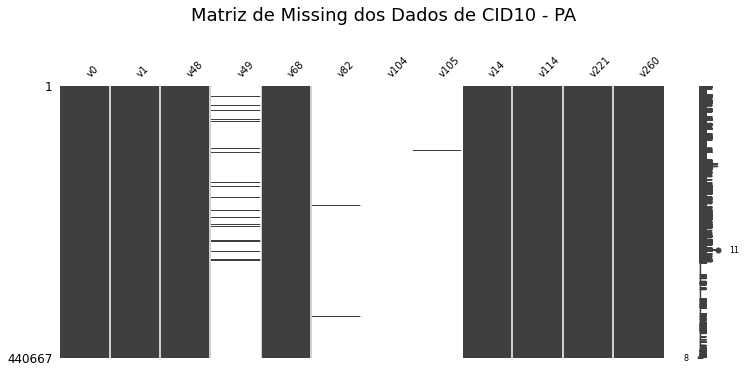

In [ ]:
msno.matrix(cid,figsize=(12, 5), fontsize=10)
plt.suptitle('Matriz de Missing dos Dados de CID10 - PA',y=1.1,fontsize=18)
plt.show()

###Fazendo o Gráfico de Barras dos Casos de Missing para as Variáveis de CID10.

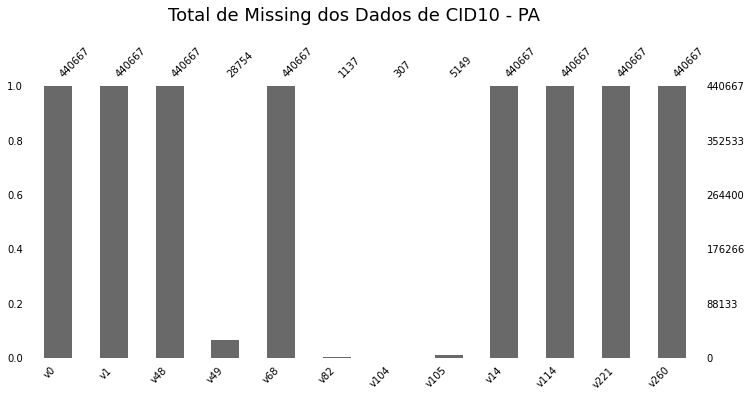

In [ ]:
msno.bar(cid,figsize=(12, 5), fontsize=10, p=False)
plt.suptitle('Total de Missing dos Dados de CID10 - PA',y=1.1,fontsize=18)
plt.show()

In [ ]:
colunas = ['v49','v82','v104','v105']

##Fazendo os Percentuais para as Variáveis de CID10.

In [ ]:
print('\033[1m'+'Percentual de Dados nas Variáveis de CID-10 - PA'+'\033[0m')
for i in range (len(colunas)):
  percentual = 100*(cid[colunas[i]].count()/cid['v48'].count())
  print('O percentual de dados em ', colunas[i], 'é de ', percentual,'%')

Percentual de Dados nas Variáveis de CID-10 - PA
O percentual de dados em  v49 é de  6.525108528662233 %
O percentual de dados em  v82 é de  0.258017959139214 %
O percentual de dados em  v104 é de  0.06966711825482734 %
O percentual de dados em  v105 é de  1.1684559996550683 %


In [ ]:
for col in cid:
  print('\033[1m'+'Dados na Variável '+col+' (por Frequência)'+'\033[0m')
  print(cid[col].value_counts())
  print('\n')

Dados na Variável v0 (por Frequência)
150000    111607
150140     95789
150080     28620
150680     16181
150240     16084
           ...  
150307        73
150250        36
150340        31
150440        25
150497         4
Name: v0, Length: 103, dtype: int64


Dados na Variável v1 (por Frequência)
2009    43672
2010    42756
2011    41921
2013    40986
2017    40967
2008    39635
2018    39344
2012    39205
2014    39084
2015    37152
2016    35945
Name: v1, dtype: int64


Dados na Variável v48 (por Frequência)
O800    42624
A09     18023
J189     9748
J459     8660
N390     8530
        ...  
P143        1
M991        1
F169        1
J940        1
F011        1
Name: v48, Length: 4331, dtype: int64


Dados na Variável v49 (por Frequência)
W999    11474
W199     1652
X599     1557
V99      1493
X209      844
        ...  
X919        1
O828        1
W353        1
X909        1
V872        1
Name: v49, Length: 1013, dtype: int64


Dados na Variável v68 (por Frequência)
0    432044
1  

##Criando as Variáveis de Grupo do CID10.  

In [ ]:
colunas2 = ['v48','v49','v82','v104','v105']

In [ ]:
for i in range(len(colunas2)):
  cid['v{0}'.format(253+i)] = cid[colunas2[i]].astype(str).str[0:2]
cid = cid.replace({'na':np.nan})
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,150000,2008,I630,NaN,0,NaN,NaN,NaN,3,3,88,6.0,I6,NaN,NaN,NaN,NaN
1,150000,2008,N390,NaN,0,NaN,NaN,NaN,1,1,0,24.0,N3,NaN,NaN,NaN,NaN
2,150000,2008,J960,NaN,0,NaN,NaN,NaN,1,99,3,3.0,J9,NaN,NaN,NaN,NaN
3,150000,2008,N159,NaN,0,NaN,NaN,NaN,3,99,49,3.0,N1,NaN,NaN,NaN,NaN
4,150000,2008,N159,NaN,0,NaN,NaN,NaN,3,99,34,3.0,N1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,J110,NaN,0,NaN,NaN,NaN,3,99,0,2.0,J1,NaN,NaN,NaN,NaN
440663,150840,2018,K800,NaN,0,NaN,NaN,NaN,3,99,26,3.0,K8,NaN,NaN,NaN,NaN
440664,150840,2018,K800,NaN,0,NaN,NaN,NaN,3,99,57,3.0,K8,NaN,NaN,NaN,NaN
440665,150840,2018,K800,NaN,0,NaN,NaN,NaN,3,99,27,3.0,K8,NaN,NaN,NaN,NaN


##Substituindo os valores de Missing pela string 'vazio'

In [ ]:
cidfull = cid.fillna('vazio')
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,150000,2008,I630,vazio,0,vazio,vazio,vazio,3,3,88,6.0,I6,vazio,vazio,vazio,vazio
1,150000,2008,N390,vazio,0,vazio,vazio,vazio,1,1,0,24.0,N3,vazio,vazio,vazio,vazio
2,150000,2008,J960,vazio,0,vazio,vazio,vazio,1,99,3,3.0,J9,vazio,vazio,vazio,vazio
3,150000,2008,N159,vazio,0,vazio,vazio,vazio,3,99,49,3.0,N1,vazio,vazio,vazio,vazio
4,150000,2008,N159,vazio,0,vazio,vazio,vazio,3,99,34,3.0,N1,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,J110,vazio,0,vazio,vazio,vazio,3,99,0,2.0,J1,vazio,vazio,vazio,vazio
440663,150840,2018,K800,vazio,0,vazio,vazio,vazio,3,99,26,3.0,K8,vazio,vazio,vazio,vazio
440664,150840,2018,K800,vazio,0,vazio,vazio,vazio,3,99,57,3.0,K8,vazio,vazio,vazio,vazio
440665,150840,2018,K800,vazio,0,vazio,vazio,vazio,3,99,27,3.0,K8,vazio,vazio,vazio,vazio


##Transformando as Variáveis de CID10 em Variáveis com Categorias Numéricas.

In [ ]:
a = cidfull['v48'].unique()
b = cidfull['v49'].unique()
c = cidfull['v82'].unique()
d = cidfull['v104'].unique()
e = cidfull['v105'].unique()

In [ ]:
f=np.concatenate([a,b,c,d,e],axis=0)
f = pd.DataFrame(f.T)
f

,0
0,I630
1,N390
2,J960
3,N159
4,J128
...,...
6304,K818
6305,J953
6306,O650
6307,I694


In [ ]:
lecidpa = preprocessing.LabelEncoder()
lecidpa.fit(f)
for i in range(len(colunas2)):
  cidfull[colunas2[i]]=lecidpa.transform(cidfull[colunas2[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,150000,2008,1633,5194,0,5194,5194,5194,3,3,88,6.0,I6,vazio,vazio,vazio,vazio
1,150000,2008,2745,5194,0,5194,5194,5194,1,1,0,24.0,N3,vazio,vazio,vazio,vazio
2,150000,2008,1852,5194,0,5194,5194,5194,1,99,3,3.0,J9,vazio,vazio,vazio,vazio
3,150000,2008,2674,5194,0,5194,5194,5194,3,99,49,3.0,N1,vazio,vazio,vazio,vazio
4,150000,2008,2674,5194,0,5194,5194,5194,3,99,34,3.0,N1,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,1736,5194,0,5194,5194,5194,3,99,0,2.0,J1,vazio,vazio,vazio,vazio
440663,150840,2018,2120,5194,0,5194,5194,5194,3,99,26,3.0,K8,vazio,vazio,vazio,vazio
440664,150840,2018,2120,5194,0,5194,5194,5194,3,99,57,3.0,K8,vazio,vazio,vazio,vazio
440665,150840,2018,2120,5194,0,5194,5194,5194,3,99,27,3.0,K8,vazio,vazio,vazio,vazio


In [ ]:
a1 = cidfull['v253'].unique()
b1 = cidfull['v254'].unique()
c1 = cidfull['v255'].unique()
d1 = cidfull['v256'].unique()
e1 = cidfull['v257'].unique()

In [ ]:
f1=np.concatenate([a1,b1,c1,d1,e1],axis=0)
f1 = pd.DataFrame(f1.T)
f1

,0
0,I6
1,N3
2,J9
3,N1
4,J1
...,...
577,F1
578,T2
579,T4
580,S4


In [ ]:
colunas3 = ['v253','v254','v255','v256','v257']

In [ ]:
lecidpa1 = preprocessing.LabelEncoder()
lecidpa1.fit(f1)
for i in range(len(colunas2)):
  cidfull[colunas3[i]]=lecidpa1.transform(cidfull[colunas3[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,150000,2008,1633,5194,0,5194,5194,5194,3,3,88,6.0,83,242,242,242,242
1,150000,2008,2745,5194,0,5194,5194,5194,1,1,0,24.0,127,242,242,242,242
2,150000,2008,1852,5194,0,5194,5194,5194,1,99,3,3.0,94,242,242,242,242
3,150000,2008,2674,5194,0,5194,5194,5194,3,99,49,3.0,125,242,242,242,242
4,150000,2008,2674,5194,0,5194,5194,5194,3,99,34,3.0,125,242,242,242,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,1736,5194,0,5194,5194,5194,3,99,0,2.0,88,242,242,242,242
440663,150840,2018,2120,5194,0,5194,5194,5194,3,99,26,3.0,103,242,242,242,242
440664,150840,2018,2120,5194,0,5194,5194,5194,3,99,57,3.0,103,242,242,242,242
440665,150840,2018,2120,5194,0,5194,5194,5194,3,99,27,3.0,103,242,242,242,242


##Criando as Variáves de Análise de Falha de Diagnóstico e de Condição de Óbito.

In [ ]:
cidfull.loc[((cidfull['v49']==5194)&(cidfull['v82']==5194)&(cidfull['v104']==5194)&(cidfull['v105']==5194))&((cidfull['v254']==242)&(cidfull['v255']==242)&(cidfull['v256']==242)&(cidfull['v257']==242)),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']==cidfull['v49'])|(cidfull['v48']==cidfull['v82'])|(cidfull['v48']==cidfull['v104'])|(cidfull['v48']==cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])|(cidfull['v48']!=cidfull['v82'])|(cidfull['v48']!=cidfull['v104'])|(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Equivocado'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])&(cidfull['v48']!=cidfull['v82'])&(cidfull['v48']!=cidfull['v104'])&(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']!=cidfull['v254'])&(cidfull['v253']!=cidfull['v255'])&(cidfull['v253']!=cidfull['v256'])&(cidfull['v253']!=cidfull['v257']))&((cidfull['v254']!=242)|(cidfull['v255']!=242)|(cidfull['v256']!=242)|(cidfull['v257']!=242)),'v258']='Falha de Diagnóstico'
cidfull.loc[cidfull['v68']==0,'v259']='Não houve óbito'
cidfull.loc[(cidfull['v257']==242)&(cidfull['v68']==1),'v259']='Houve óbito sem CID10 declarada'
cidfull.loc[(cidfull['v257']!=242)&(cidfull['v68']==1),'v259']='Houve óbito com CID10 declarada'
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259
0,150000,2008,1633,5194,0,5194,5194,5194,3,3,88,6.0,83,242,242,242,242,Diagnóstico Correto,Não houve óbito
1,150000,2008,2745,5194,0,5194,5194,5194,1,1,0,24.0,127,242,242,242,242,Diagnóstico Correto,Não houve óbito
2,150000,2008,1852,5194,0,5194,5194,5194,1,99,3,3.0,94,242,242,242,242,Diagnóstico Correto,Não houve óbito
3,150000,2008,2674,5194,0,5194,5194,5194,3,99,49,3.0,125,242,242,242,242,Diagnóstico Correto,Não houve óbito
4,150000,2008,2674,5194,0,5194,5194,5194,3,99,34,3.0,125,242,242,242,242,Diagnóstico Correto,Não houve óbito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,1736,5194,0,5194,5194,5194,3,99,0,2.0,88,242,242,242,242,Diagnóstico Correto,Não houve óbito
440663,150840,2018,2120,5194,0,5194,5194,5194,3,99,26,3.0,103,242,242,242,242,Diagnóstico Correto,Não houve óbito
440664,150840,2018,2120,5194,0,5194,5194,5194,3,99,57,3.0,103,242,242,242,242,Diagnóstico Correto,Não houve óbito
440665,150840,2018,2120,5194,0,5194,5194,5194,3,99,27,3.0,103,242,242,242,242,Diagnóstico Correto,Não houve óbito


##Fazendo o Download de Arquivo de Custos de Atendimento Médico, Criando um Dataframe e Fazendo o Merge de Arquivos para Obter os Custos Relativos às Internações.  

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1corB_xGrJ3NDFpIXuKDl6Dri_tlPLzI0'})
fileDownloaded.GetContentFile('anual.xlsx')
anual = pd.read_excel('anual.xlsx',sheet_name='anual')

In [ ]:
anual['cep'] = [i[0] for i in anual.v241.str.split(' ').values]

In [ ]:
anual['cep']=anual['cep'].astype('int64')
anual.columns = ['v1',	'v241',	'v242',	'v243',	'v244',	'v245',	'v246',	'v247',	'v248',	'v249',	'v250',	'v261','v251',	'v252','v0']

In [ ]:
full = pd.merge(cidfull,anual[['v0','v1','v261']], on=['v0','v1'],how='left')

In [ ]:
full = full.fillna(0)
full['v262'] = full['v260']*full['v261']
full['v14'] = full['v14'].replace({1:'M',2:'F',3:'F'})
full['v114'] = full['v114'].replace({1:'Branca',2:'Preta',3:'Parda', 4:'Amarela', 5:'Vermelha', 99:'Não Declarada'})
full

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259,v261,v262
0,150000,2008,1633,5194,0,5194,5194,5194,F,Parda,88,6.0,83,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
1,150000,2008,2745,5194,0,5194,5194,5194,M,Branca,0,24.0,127,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
2,150000,2008,1852,5194,0,5194,5194,5194,M,Não Declarada,3,3.0,94,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
3,150000,2008,2674,5194,0,5194,5194,5194,F,Não Declarada,49,3.0,125,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
4,150000,2008,2674,5194,0,5194,5194,5194,F,Não Declarada,34,3.0,125,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440662,150840,2018,1736,5194,0,5194,5194,5194,F,Não Declarada,0,2.0,88,242,242,242,242,Diagnóstico Correto,Não houve óbito,150.16,300.32
440663,150840,2018,2120,5194,0,5194,5194,5194,F,Não Declarada,26,3.0,103,242,242,242,242,Diagnóstico Correto,Não houve óbito,150.16,450.48
440664,150840,2018,2120,5194,0,5194,5194,5194,F,Não Declarada,57,3.0,103,242,242,242,242,Diagnóstico Correto,Não houve óbito,150.16,450.48
440665,150840,2018,2120,5194,0,5194,5194,5194,F,Não Declarada,27,3.0,103,242,242,242,242,Diagnóstico Correto,Não houve óbito,150.16,450.48


##Imprimindo algumas Métricas Encontradas.

In [ ]:
p1 = 100*full['v258'].value_counts()/len(full)
p2 = 100*full['v259'].value_counts()/len(full)
p3 = 100*full['v258'].groupby(full['v259']).value_counts()/len(full)
p4 = 100*full['v258'].groupby(full['v259']).value_counts(normalize = True)
p5 = 100*full['v258'].groupby(full['v14']).value_counts()/len(full)
p6 = 100*full['v258'].groupby(full['v14']).value_counts(normalize = True)
p7 = 100*full['v49'].groupby(full['v258']).value_counts()/len(full)
p8 = 100*full['v49'].groupby(full['v258']).value_counts(normalize = True)
p9 = 100*full['v105'].groupby(full['v258']).value_counts()/len(full)
p10 = 100*full['v105'].groupby(full['v258']).value_counts(normalize = True)
p13 = 100*full['v114'].groupby(full['v258']).value_counts()/len(full)
p14 = 100*full['v114'].groupby(full['v258']).value_counts(normalize = True)
p11 = full.groupby(['v258','v259']).agg({'v262': ['mean', 'median', 'min', 'max','std']})
p12 = full.groupby(['v258','v259']).agg({'v260': ['mean', 'median', 'min', 'max','std']})
dc1 = list(lecidpa.inverse_transform([5194]))
de1 = list(lecidpa.inverse_transform([5194,4772,2660,1413]))
df1 = list(lecidpa.inverse_transform([5176,5178,5181,5192,5193]))
dc2 = list(lecidpa.inverse_transform([5194]))
de2 = list(lecidpa.inverse_transform([5194,1642,106,1852]))
df2 = list(lecidpa.inverse_transform([5091,5132,5134,5157,5188]))
print('\033[1m'+'Análise dos Pecentuais de Diagnóstico'+'\033[0m')
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico')
print(p1)
print('\n')
print('Percentual Total de Diagnósticos por Condição de Óbito')
print(p2)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito')
print(p3)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Condição de Óbito')
print(p4)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Gênero')
print(p5)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pelo Gênero')
print(p6)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p7)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p8)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Houve Óbito')
print(p9)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Houve Óbito')
print(p10)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Custos de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p11)
print('\n')
print('Tempo de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p12)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Raça')
print(p13)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Raça')
print(p14)
print('\n')

Análise dos Pecentuais de Diagnóstico


Percentual Total de Cada Tipo de Diagnóstico
Diagnóstico Correto       92.12
Falha de Diagnóstico       6.84
Diagnóstico Equivocado     1.04
Name: v258, dtype: float64


Percentual Total de Diagnósticos por Condição de Óbito
Não houve óbito                    98.04
Houve óbito com CID10 declarada     1.17
Houve óbito sem CID10 declarada     0.79
Name: v259, dtype: float64


Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito
v259                             v258                  
Houve óbito com CID10 declarada  Diagnóstico Equivocado     0.79
                                 Falha de Diagnóstico       0.38
Houve óbito sem CID10 declarada  Diagnóstico Correto        0.79
Não houve óbito                  Diagnóstico Correto       91.33
                                 Falha de Diagnóstico       6.46
                                 Diagnóstico Equivocado     0.25
Name: v258, dtype: float64


Percentual Relativo de Cada Tipo de Diagnóst

#Análises para o Estado de Goiás .

##Criando a Variável de Dias de Internação. 

In [ ]:
GO['v260'] = pd.to_datetime(GO['v47'],format='%Y%m%d')-pd.to_datetime(GO['v46'],format='%Y%m%d')

In [ ]:
GO['v260'] = GO['v260'].astype('timedelta64[D]')

##Criando um Subset para Análise das Variáves de CID10. 

In [ ]:
cid = (GO[['v0','v1','v48','v49', 'v68','v82','v104','v105','v14','v114','v221','v260']]).copy()

In [ ]:
cid[['v49','v82','v104','v105']] = cid[['v49','v82','v104','v105']].replace({'0':np.nan})

In [ ]:
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260
0,520000,2008,J459,NaN,0,NaN,NaN,NaN,3,1,39,2.0
1,520000,2008,I843,NaN,0,NaN,NaN,NaN,3,99,30,1.0
2,520000,2008,K801,NaN,0,NaN,NaN,NaN,3,99,19,1.0
3,520000,2008,K801,NaN,0,NaN,NaN,NaN,3,99,51,1.0
4,520000,2008,I839,NaN,0,NaN,NaN,NaN,3,99,73,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,O828,NaN,0,NaN,NaN,NaN,3,99,30,1.0
310739,522205,2018,T630,NaN,0,NaN,NaN,NaN,1,99,51,2.0
310740,522205,2018,B955,NaN,0,NaN,NaN,NaN,1,99,60,2.0
310741,522205,2018,H600,NaN,0,NaN,NaN,NaN,1,99,1,1.0


##Verificando os dados de Missing das Variáveis de CID10.

###Fazendo a Matriz dos Casos de Missing para as Variáveis de CID10.

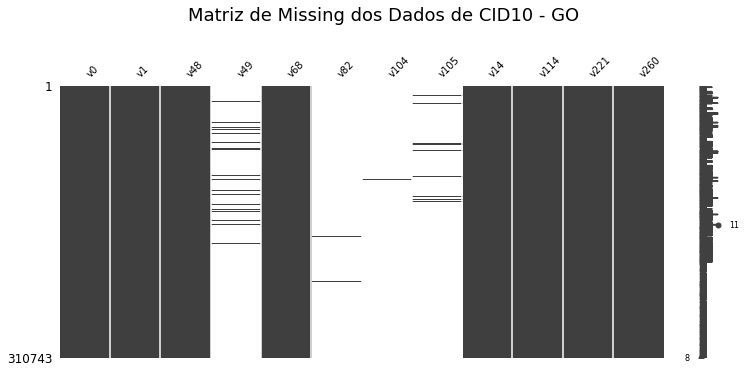

In [ ]:
msno.matrix(cid,figsize=(12, 5), fontsize=10)
plt.suptitle('Matriz de Missing dos Dados de CID10 - GO',y=1.1,fontsize=18)
plt.show()

###Fazendo o Gráfico de Barras dos Casos de Missing para as Variáveis de CID10.

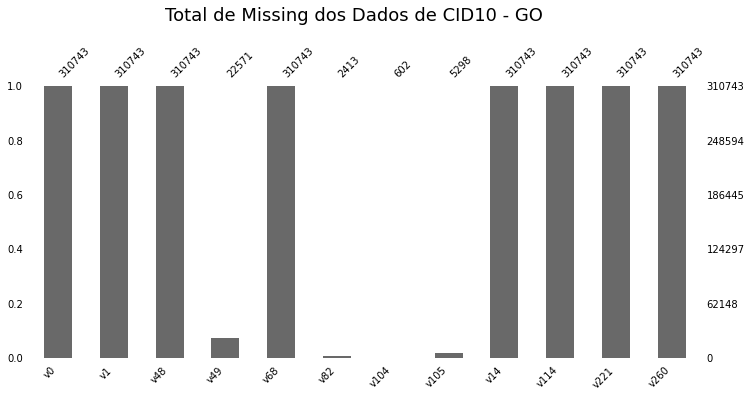

In [ ]:
msno.bar(cid,figsize=(12, 5), fontsize=10, p=False)
plt.suptitle('Total de Missing dos Dados de CID10 - GO',y=1.1,fontsize=18)
plt.show()

In [ ]:
colunas = ['v49','v82','v104','v105']

##Fazendo os Percentuais para as Variáveis de CID10.

In [ ]:
print('\033[1m'+'Percentual de Dados nas Variáveis de CID-10 - GO'+'\033[0m')
for i in range (len(colunas)):
  percentual = 100*(cid[colunas[i]].count()/cid['v48'].count())
  print('O percentual de dados em ', colunas[i], 'é de ', percentual,'%')

Percentual de Dados nas Variáveis de CID-10 - GO
O percentual de dados em  v49 é de  7.263558632052853 %
O percentual de dados em  v82 é de  0.7765259394419183 %
O percentual de dados em  v104 é de  0.19372922318443214 %
O percentual de dados em  v105 é de  1.704945887759338 %


In [ ]:
for col in cid:
  print('\033[1m'+'Dados na Variável '+col+' (por Frequência)'+'\033[0m')
  print(cid[col].value_counts())
  print('\n')

Dados na Variável v0 (por Frequência)
520870    125768
520110     29817
520000     22724
520140     16027
521880      8402
           ...  
521500        31
520480        29
520993        24
520660        23
521030         6
Name: v0, Length: 181, dtype: int64


Dados na Variável v1 (por Frequência)
2009    31522
2010    29793
2014    29435
2011    28469
2013    28432
2008    28137
2015    27468
2018    27438
2017    27206
2012    26602
2016    26241
Name: v1, dtype: int64


Dados na Variável v48 (por Frequência)
J189    10134
O800     8475
O809     7402
O829     6755
A09      5387
        ...  
N420        1
M051        1
T918        1
C939        1
K130        1
Name: v48, Length: 4932, dtype: int64


Dados na Variável v49 (por Frequência)
W199    6137
W189    2276
V299    1358
V99      957
X599     829
        ... 
F03        1
X490       1
X272       1
X700       1
V220       1
Name: v49, Length: 1019, dtype: int64


Dados na Variável v68 (por Frequência)
0    301868
1      8875
Na

##Criando as Variáveis de Grupo do CID10.  

In [ ]:
colunas2 = ['v48','v49','v82','v104','v105']

In [ ]:
for i in range(len(colunas2)):
  cid['v{0}'.format(253+i)] = cid[colunas2[i]].astype(str).str[0:2]
cid = cid.replace({'na':np.nan})
cid

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,520000,2008,J459,NaN,0,NaN,NaN,NaN,3,1,39,2.0,J4,NaN,NaN,NaN,NaN
1,520000,2008,I843,NaN,0,NaN,NaN,NaN,3,99,30,1.0,I8,NaN,NaN,NaN,NaN
2,520000,2008,K801,NaN,0,NaN,NaN,NaN,3,99,19,1.0,K8,NaN,NaN,NaN,NaN
3,520000,2008,K801,NaN,0,NaN,NaN,NaN,3,99,51,1.0,K8,NaN,NaN,NaN,NaN
4,520000,2008,I839,NaN,0,NaN,NaN,NaN,3,99,73,2.0,I8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,O828,NaN,0,NaN,NaN,NaN,3,99,30,1.0,O8,NaN,NaN,NaN,NaN
310739,522205,2018,T630,NaN,0,NaN,NaN,NaN,1,99,51,2.0,T6,NaN,NaN,NaN,NaN
310740,522205,2018,B955,NaN,0,NaN,NaN,NaN,1,99,60,2.0,B9,NaN,NaN,NaN,NaN
310741,522205,2018,H600,NaN,0,NaN,NaN,NaN,1,99,1,1.0,H6,NaN,NaN,NaN,NaN


##Substituindo os valores de Missing pela string 'vazio'

In [ ]:
cidfull = cid.fillna('vazio')
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,520000,2008,J459,vazio,0,vazio,vazio,vazio,3,1,39,2.0,J4,vazio,vazio,vazio,vazio
1,520000,2008,I843,vazio,0,vazio,vazio,vazio,3,99,30,1.0,I8,vazio,vazio,vazio,vazio
2,520000,2008,K801,vazio,0,vazio,vazio,vazio,3,99,19,1.0,K8,vazio,vazio,vazio,vazio
3,520000,2008,K801,vazio,0,vazio,vazio,vazio,3,99,51,1.0,K8,vazio,vazio,vazio,vazio
4,520000,2008,I839,vazio,0,vazio,vazio,vazio,3,99,73,2.0,I8,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,O828,vazio,0,vazio,vazio,vazio,3,99,30,1.0,O8,vazio,vazio,vazio,vazio
310739,522205,2018,T630,vazio,0,vazio,vazio,vazio,1,99,51,2.0,T6,vazio,vazio,vazio,vazio
310740,522205,2018,B955,vazio,0,vazio,vazio,vazio,1,99,60,2.0,B9,vazio,vazio,vazio,vazio
310741,522205,2018,H600,vazio,0,vazio,vazio,vazio,1,99,1,1.0,H6,vazio,vazio,vazio,vazio


##Transformando as Variáveis de CID10 em Variáveis com Categorias Numéricas.

In [ ]:
a = cidfull['v48'].unique()
b = cidfull['v49'].unique()
c = cidfull['v82'].unique()
d = cidfull['v104'].unique()
e = cidfull['v105'].unique()

In [ ]:
f=np.concatenate([a,b,c,d,e],axis=0)
f = pd.DataFrame(f.T)
f

,0
0,J459
1,I843
2,K801
3,I839
4,D259
...,...
6904,B589
6905,T131
6906,A403
6907,F03


In [ ]:
lecidgo = preprocessing.LabelEncoder()
lecidgo.fit(f)
for i in range(len(colunas2)):
  cidfull[colunas2[i]]=lecidgo.transform(cidfull[colunas2[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,520000,2008,2166,5554,0,5554,5554,5554,3,1,39,2.0,J4,vazio,vazio,vazio,vazio
1,520000,2008,2028,5554,0,5554,5554,5554,3,99,30,1.0,I8,vazio,vazio,vazio,vazio
2,520000,2008,2494,5554,0,5554,5554,5554,3,99,19,1.0,K8,vazio,vazio,vazio,vazio
3,520000,2008,2494,5554,0,5554,5554,5554,3,99,51,1.0,K8,vazio,vazio,vazio,vazio
4,520000,2008,2024,5554,0,5554,5554,5554,3,99,73,2.0,I8,vazio,vazio,vazio,vazio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,3597,5554,0,5554,5554,5554,3,99,30,1.0,O8,vazio,vazio,vazio,vazio
310739,522205,2018,4759,5554,0,5554,5554,5554,1,99,51,2.0,T6,vazio,vazio,vazio,vazio
310740,522205,2018,362,5554,0,5554,5554,5554,1,99,60,2.0,B9,vazio,vazio,vazio,vazio
310741,522205,2018,1702,5554,0,5554,5554,5554,1,99,1,1.0,H6,vazio,vazio,vazio,vazio


In [ ]:
a1 = cidfull['v253'].unique()
b1 = cidfull['v254'].unique()
c1 = cidfull['v255'].unique()
d1 = cidfull['v256'].unique()
e1 = cidfull['v257'].unique()

In [ ]:
f1=np.concatenate([a1,b1,c1,d1,e1],axis=0)
f1 = pd.DataFrame(f1.T)
f1

,0
0,J4
1,I8
2,K8
3,D2
4,N4
...,...
630,O9
631,M0
632,L9
633,O8


In [ ]:
colunas3 = ['v253','v254','v255','v256','v257']

In [ ]:
lecidgo1 = preprocessing.LabelEncoder()
lecidgo1.fit(f1)
for i in range(len(colunas2)):
  cidfull[colunas3[i]]=lecidgo1.transform(cidfull[colunas3[i]])
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257
0,520000,2008,2166,5554,0,5554,5554,5554,3,1,39,2.0,92,242,242,242,242
1,520000,2008,2028,5554,0,5554,5554,5554,3,99,30,1.0,86,242,242,242,242
2,520000,2008,2494,5554,0,5554,5554,5554,3,99,19,1.0,104,242,242,242,242
3,520000,2008,2494,5554,0,5554,5554,5554,3,99,51,1.0,104,242,242,242,242
4,520000,2008,2024,5554,0,5554,5554,5554,3,99,73,2.0,86,242,242,242,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,3597,5554,0,5554,5554,5554,3,99,30,1.0,143,242,242,242,242
310739,522205,2018,4759,5554,0,5554,5554,5554,1,99,51,2.0,190,242,242,242,242
310740,522205,2018,362,5554,0,5554,5554,5554,1,99,60,2.0,18,242,242,242,242
310741,522205,2018,1702,5554,0,5554,5554,5554,1,99,1,1.0,74,242,242,242,242


##Criando as Variáves de Análise de Falha de Diagnóstico e de Condição de Óbito.

In [ ]:
cidfull.loc[((cidfull['v49']==5554)&(cidfull['v82']==5554)&(cidfull['v104']==5554)&(cidfull['v105']==5554))&((cidfull['v254']==242)&(cidfull['v255']==242)&(cidfull['v256']==242)&(cidfull['v257']==242)),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']==cidfull['v49'])|(cidfull['v48']==cidfull['v82'])|(cidfull['v48']==cidfull['v104'])|(cidfull['v48']==cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Correto'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])|(cidfull['v48']!=cidfull['v82'])|(cidfull['v48']!=cidfull['v104'])|(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']==cidfull['v254'])|(cidfull['v253']==cidfull['v255'])|(cidfull['v253']==cidfull['v256'])|(cidfull['v253']==cidfull['v257'])),'v258']='Diagnóstico Equivocado'
cidfull.loc[((cidfull['v48']!=cidfull['v49'])&(cidfull['v48']!=cidfull['v82'])&(cidfull['v48']!=cidfull['v104'])&(cidfull['v48']!=cidfull['v105']))&((cidfull['v253']!=cidfull['v254'])&(cidfull['v253']!=cidfull['v255'])&(cidfull['v253']!=cidfull['v256'])&(cidfull['v253']!=cidfull['v257']))&((cidfull['v254']!=242)|(cidfull['v255']!=242)|(cidfull['v256']!=242)|(cidfull['v257']!=242)),'v258']='Falha de Diagnóstico'
cidfull.loc[cidfull['v68']==0,'v259']='Não houve óbito'
cidfull.loc[(cidfull['v257']==242)&(cidfull['v68']==1),'v259']='Houve óbito sem CID10 declarada'
cidfull.loc[(cidfull['v257']!=242)&(cidfull['v68']==1),'v259']='Houve óbito com CID10 declarada'
cidfull

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259
0,520000,2008,2166,5554,0,5554,5554,5554,3,1,39,2.0,92,242,242,242,242,Diagnóstico Correto,Não houve óbito
1,520000,2008,2028,5554,0,5554,5554,5554,3,99,30,1.0,86,242,242,242,242,Diagnóstico Correto,Não houve óbito
2,520000,2008,2494,5554,0,5554,5554,5554,3,99,19,1.0,104,242,242,242,242,Diagnóstico Correto,Não houve óbito
3,520000,2008,2494,5554,0,5554,5554,5554,3,99,51,1.0,104,242,242,242,242,Diagnóstico Correto,Não houve óbito
4,520000,2008,2024,5554,0,5554,5554,5554,3,99,73,2.0,86,242,242,242,242,Diagnóstico Correto,Não houve óbito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,3597,5554,0,5554,5554,5554,3,99,30,1.0,143,242,242,242,242,Diagnóstico Correto,Não houve óbito
310739,522205,2018,4759,5554,0,5554,5554,5554,1,99,51,2.0,190,242,242,242,242,Diagnóstico Correto,Não houve óbito
310740,522205,2018,362,5554,0,5554,5554,5554,1,99,60,2.0,18,242,242,242,242,Diagnóstico Correto,Não houve óbito
310741,522205,2018,1702,5554,0,5554,5554,5554,1,99,1,1.0,74,242,242,242,242,Diagnóstico Correto,Não houve óbito


##Fazendo o Download de Arquivo de Custos de Atendimento Médico, Criando um Dataframe e Fazendo o Merge de Arquivos para Obter os Custos Relativos às Internações.  

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1corB_xGrJ3NDFpIXuKDl6Dri_tlPLzI0'})
fileDownloaded.GetContentFile('anual.xlsx')
anual = pd.read_excel('anual.xlsx',sheet_name='anual')

In [ ]:
anual['cep'] = [i[0] for i in anual.v241.str.split(' ').values]

In [ ]:
anual['cep']=anual['cep'].astype('int64')
anual.columns = ['v1',	'v241',	'v242',	'v243',	'v244',	'v245',	'v246',	'v247',	'v248',	'v249',	'v250',	'v261','v251',	'v252','v0']

In [ ]:
full = pd.merge(cidfull,anual[['v0','v1','v261']], on=['v0','v1'],how='left')

In [ ]:
full = full.fillna(0)
full['v262'] = full['v260']*full['v261']
full['v14'] = full['v14'].replace({1:'M',2:'F',3:'F'})
full['v114'] = full['v114'].replace({1:'Branca',2:'Preta',3:'Parda', 4:'Amarela', 5:'Vermelha', 99:'Não Declarada'})
full

,v0,v1,v48,v49,v68,v82,v104,v105,v14,v114,v221,v260,v253,v254,v255,v256,v257,v258,v259,v261,v262
0,520000,2008,2166,5554,0,5554,5554,5554,F,Branca,39,2.0,92,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
1,520000,2008,2028,5554,0,5554,5554,5554,F,Não Declarada,30,1.0,86,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
2,520000,2008,2494,5554,0,5554,5554,5554,F,Não Declarada,19,1.0,104,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
3,520000,2008,2494,5554,0,5554,5554,5554,F,Não Declarada,51,1.0,104,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
4,520000,2008,2024,5554,0,5554,5554,5554,F,Não Declarada,73,2.0,86,242,242,242,242,Diagnóstico Correto,Não houve óbito,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310738,522205,2018,3597,5554,0,5554,5554,5554,F,Não Declarada,30,1.0,143,242,242,242,242,Diagnóstico Correto,Não houve óbito,165.28,165.28
310739,522205,2018,4759,5554,0,5554,5554,5554,M,Não Declarada,51,2.0,190,242,242,242,242,Diagnóstico Correto,Não houve óbito,165.28,330.56
310740,522205,2018,362,5554,0,5554,5554,5554,M,Não Declarada,60,2.0,18,242,242,242,242,Diagnóstico Correto,Não houve óbito,165.28,330.56
310741,522205,2018,1702,5554,0,5554,5554,5554,M,Não Declarada,1,1.0,74,242,242,242,242,Diagnóstico Correto,Não houve óbito,165.28,165.28


##Imprimindo algumas Métricas Encontradas.

In [ ]:
p1 = 100*full['v258'].value_counts()/len(full)
p2 = 100*full['v259'].value_counts()/len(full)
p3 = 100*full['v258'].groupby(full['v259']).value_counts()/len(full)
p4 = 100*full['v258'].groupby(full['v259']).value_counts(normalize = True)
p5 = 100*full['v258'].groupby(full['v14']).value_counts()/len(full)
p6 = 100*full['v258'].groupby(full['v14']).value_counts(normalize = True)
p7 = 100*full['v49'].groupby(full['v258']).value_counts()/len(full)
p8 = 100*full['v49'].groupby(full['v258']).value_counts(normalize = True)
p9 = 100*full['v105'].groupby(full['v258']).value_counts()/len(full)
p10 = 100*full['v105'].groupby(full['v258']).value_counts(normalize = True)
p11 = full.groupby(['v258','v259']).agg({'v262': ['mean', 'median', 'min', 'max','std']})
p12 = full.groupby(['v258','v259']).agg({'v260': ['mean', 'median', 'min', 'max','std']})
p13 = 100*full['v114'].groupby(full['v258']).value_counts()/len(full)
p14 = 100*full['v114'].groupby(full['v258']).value_counts(normalize = True)
dc1 = list(lecidgo.inverse_transform([5554]))
de1 = list(lecidgo.inverse_transform([5554,5053,4953,5059]))
df1 = list(lecidgo.inverse_transform([5528,5532,5539,5548,5552]))
dc2 = list(lecidgo.inverse_transform([5554]))
de2 = list(lecidgo.inverse_transform([5554,2103,1955,1915]))
df2 = list(lecidgo.inverse_transform([4794,5384,5405,5473,5544]))
print('\033[1m'+'Análise dos Pecentuais de Diagnóstico'+'\033[0m')
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico')
print(p1)
print('\n')
print('Percentual Total de Diagnósticos por Condição de Óbito')
print(p2)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito')
print(p3)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Condição de Óbito')
print(p4)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Gênero')
print(p5)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pelo Gênero')
print(p6)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p7)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Não Houve Óbito')
print(p8)
print('Top CID10 com Diagnóstico Correto: ',dc1)
print('Top CID10 com Diagnóstico Equivocado: ',de1)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df1)
print('\n')
print('Percentual Total dos Mais Frequentes CID10 Onde Houve Óbito')
print(p9)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Percentual Relativo dos Mais Frequentes CID10 Onde Houve Óbito')
print(p10)
print('Top CID10 com Diagnóstico Correto: ',dc2)
print('Top CID10 com Diagnóstico Equivocado: ',de2)
print('Top CID10 com Diagnóstico Falha de Dagnóstico: ',df2)
print('\n')
print('Custos de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p11)
print('\n')
print('Tempo de Internação por Tipo de Diagnóstico e Condição de Óbito')
print(p12)
print('\n')
print('Percentual Total de Cada Tipo de Diagnóstico Considerando Raça')
print(p13)
print('\n')
print('Percentual Relativo de Cada Tipo de Diagnóstico Agrupado pela Raça')
print(p14)
print('\n')

Análise dos Pecentuais de Diagnóstico


Percentual Total de Cada Tipo de Diagnóstico
Diagnóstico Correto       90.37
Falha de Diagnóstico       7.98
Diagnóstico Equivocado     1.65
Name: v258, dtype: float64


Percentual Total de Diagnósticos por Condição de Óbito
Não houve óbito                    97.14
Houve óbito com CID10 declarada     1.70
Houve óbito sem CID10 declarada     1.15
Name: v259, dtype: float64


Percentual Total de Cada Tipo de Diagnóstico Considerando Óbito
v259                             v258                  
Houve óbito com CID10 declarada  Diagnóstico Equivocado     0.91
                                 Falha de Diagnóstico       0.79
Houve óbito sem CID10 declarada  Diagnóstico Correto        1.15
Não houve óbito                  Diagnóstico Correto       89.22
                                 Falha de Diagnóstico       7.19
                                 Diagnóstico Equivocado     0.73
Name: v258, dtype: float64


Percentual Relativo de Cada Tipo de Diagnóst

#Consolidação de Resultados por Gráficos de Barras.

In [ ]:
sns.set(
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
 
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":24,
                                "axes.labelsize":18})

In [ ]:
estados = ['SP','BA','PR','PA','GO']

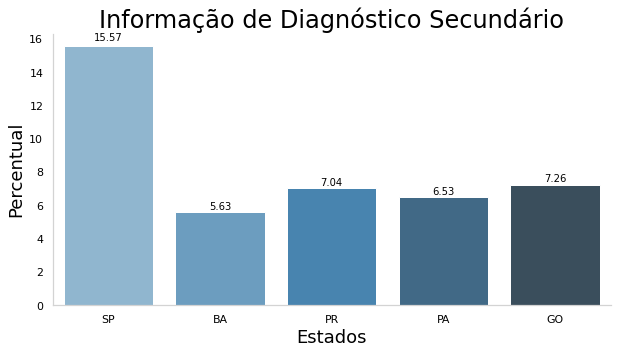

In [ ]:
per1 = [15.57,5.63,7.04,6.53,7.26]
plt.figure(figsize=(10,5))
ax = sns.barplot(estados,per1,palette="Blues_d")
plt.title('Informação de Diagnóstico Secundário')
plt.xlabel('Estados')
plt.ylabel('Percentual')      
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2f}'.format(height), (x + width/2, y + height*1.02), fontsize=10, ha='center')

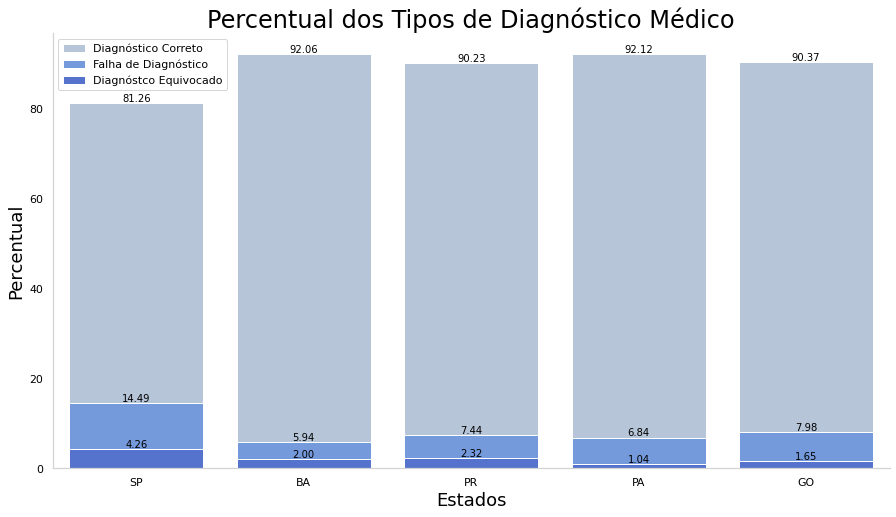

In [ ]:
pdc1 = [81.26,92.06,90.23,92.12,90.37]
pdf1 = [14.49,5.94,7.44,6.84,7.98]
pde1 = [4.26,2,2.32,1.04,1.65]
plt.figure(figsize=(15,8))
ax1 = sns.barplot(estados,pdc1,color="lightsteelblue",label='Diagnóstico Correto')
ax2 = sns.barplot(estados,pdf1,color="cornflowerblue", label='Falha de Diagnóstico')
ax3 = sns.barplot(estados,pde1,color="royalblue" ,label='Diagnóstco Equivocado')
for p in ax1.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    plt.annotate('{:.2f}'.format(height), (x + width/2, y + height+0.3), fontsize=10, ha='center')
plt.title('Percentual dos Tipos de Diagnóstico Médico')
plt.xlabel('Estados')
plt.ylabel('Percentual')
plt.legend()


In [ ]:
estados2=['(SP, Houve óbito c/ CID10)','(SP, Não houve óbito)',
          '(BA, Houve óbito c/ CID10)','(BA, Não houve óbito)',
          '(PR, Houve óbito c/ CID10)','(PR, Não houve óbito)',
          '(PA, Houve óbito c/ CID10)','(PA, Não houve óbito)',
          '(GO, Houve óbito c/ CID10)','(GO, Não houve óbito)']

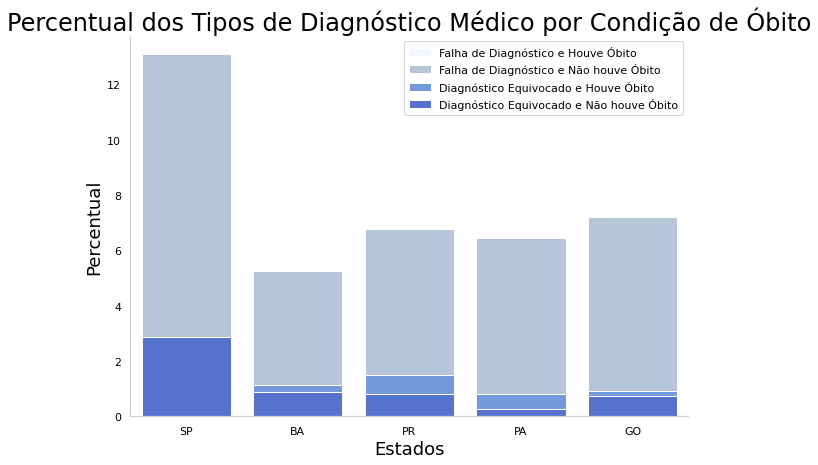

In [ ]:
pdf01 = [1.38,0.68,0.66,0.38,0.79]
pdf02 = [13.1,5.26,6.78,6.46,7.19]
pde01 = [1.42,1.12,1.51,0.79,0.91]
pde02 = [2.85,0.88,0.81,0.25,0.73]
plt.figure(figsize=(10,7))
plt.title('Percentual dos Tipos de Diagnóstico Médico por Condição de Óbito')
plt.ylabel('Percentual')
plt.xlabel('Estados')
ax2 = sns.barplot(estados, pdf01, color = "aliceblue",label='Falha de Diagnóstico e Houve Óbito')
ax3 = sns.barplot(estados, pdf02,color = "lightsteelblue", label='Falha de Diagnóstico e Não houve Óbito')
ax4 = sns.barplot(estados, pde01,color = "cornflowerblue", label='Diagnóstico Equivocado e Houve Óbito')
ax5 = sns.barplot(estados, pde02,color = "royalblue", label='Diagnóstico Equivocado e Não houve Óbito')
plt.legend()

##**RESULTADOS:**
###Após a análise de resultados, foi percepitível que a grande maioria dos atendimentos notificados representam diagnósticos corretos, salvo o fato de que eventualmente poderiam ter existir erros na inserção de dados nos bancos. Os casos onde ocorreu diagnóstico equivocado, isto é, um diagnóstico dentro do grupo de CID10 do diagnóstico possuem ordem de grandeza geralmente menor que as falhas de diagnóstico, sendo, portanto, os erros casos pouco comuns. Além disso, temos o seguinte cenário:
###**Quando houve óbito, os CIDs mais frequentes nos equívocos e falhas foram**:
###Em SP: a) Equívocos: A419 (Septicemia não especificada), J960 (Insuficiência respiratória aguda), b) Falhas: Z851 (História pessoal de neoplasia maligna de traquéia, brônquio e pulmão), Z854 (História pessoal de neoplasia maligna de órgãos genitais);
###Em BA: a) Equívocos: I64 (Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico), A419 (Septicemia não especificada), J960 (Insuficiência respiratória aguda), b) Falhas: Z850 (História pessoal de neoplasia maligna de órgãos digestivos), Z851 (História pessoal de neoplasia maligna de traquéia, brônquio e pulmão);
###Em PR: a) Equívocos:  A419 (Septicemia não especificada), I64 (Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico), b) Falhas: Z851 (História pessoal de neoplasia maligna de traquéia, brônquio e pulmão), Z914 (História pessoal de trauma psicológico não classificado em outra parte);
###Em PA: a) Equívocos:  I64 (Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico), A419 (Septicemia não especificada),  b) Falhas: Y349 (Fatos ou eventos não especificados e intenção não determinada - local não especificado), Y849 (Reação anormal em paciente ou complicação tardia, causadas por procedimento médico, não especificado, sem menção de acidente durante o procedimento);
###Em GO: a) Equívocos:  J189 (Pneumonia não especificada), I64 (Acidente vascular cerebral, não especificado como hemorrágico ou isquêmico),  b) Falhas: T811 (Choque durante ou resultante de procedimento não classificado em outra parte), Y211 (Afogamento e submersão, intenção não determinada - habitação coletiva);
###**Quando não houve óbito, os CIDs mais frequentes nos equívocos e falhas foram**:
###Em SP: a) Equívocos: G09 (Seqüelas de doenças inflamatórias do sistema nervoso central), G821 (Paraplegia espástica), b) Falhas: Z962 (Presença de implante otológicos e audiológicos), Z970 (Presença de olho artificial);
###Em BA: a) Equívocos: X939 (Agressão por meio de disparo de arma de fogo de mão - local não especificado), V209 (Motociclista traumatizado em colisão com um pedestre ou um animal - motociclista não especificado traumatizado em um acidente de trânsito),  b) Falhas: Z889 (História pessoal de alergia a drogas, medicamentos e substâncias biológicas não especificadas), Z916 (História pessoal de outros traumas físicos);
###Em PR: a) Equívocos:  W999 (Exposição a outros fatores ambientais artificiais e aos não especificados - local não especificado), W199 (Queda sem especificação - local não especificado) , b) Falhas: Z915 (História pessoal de auto agressão), Z931 (Gastrostomia); 
###Em PA: a) Equívocos:  W999 (Exposição a outros fatores ambientais artificiais e aos não especificados - local não especificado), N12 (Nefrite túbulo-intersticial não especificada se aguda ou crônica) , b) Falhas: Z574 (Exposição ocupacional a agentes tóxicos na agricultura), Z599 (Circunstâncias não especificadas econômicas ou de habitação); 
###Em GO: a) Equívocos:  W189 (Outras quedas no mesmo nível - local não especificado), V299 (Motociclista [qualquer] traumatizado em um acidente de trânsito não especificado) , b) Falhas: Z722 (Uso de droga), Z811 (História familiar de abuso de álcool).
###Além disso, pelos dados, ficou evidente que a regionalzação dos diagnósticos em si seria invitável, já que os comportamentos de CID10 variam bastante conforme o estado. Todavia, alguns outros comportamentos atendem a um certo padrão, por exemplo:
###As falhas de diagnóstico e os diagnósticos equivocados ocorrem mais para homens brancos e pardos (quando há declaração de raça) e o tempo médio de internação geralmente dobra quando há falha de diagnóstico e esta leva ao óbito do(a) paciente.    


